In [155]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import matplotlib.pyplot as plt

data = pd.read_csv('data/istanbul_data_preprocessed.csv')

name_cols = ['MainDistID', 'DistID', 'HcoID', 'SkuID']
categorical_cols = ['SalesRegionID_x','SalesRegionID_y', 'HcoType', 'District', 'Status', ]
numerical_cols = ['PaidQty', 'FGQty', 'TotalQuantity']
boolean_cols = ['IsReturn', 'IsMrsOrder']
data['Date'] = pd.to_datetime(data['Date'])

# convert categorical columns to 'category' data type
for col in categorical_cols:
    data[col] = data[col].astype('category')

# convert numerical columns to 'int' data type
for col in numerical_cols:
    data[col] = data[col].astype('int')
    
# convert name columns to str data type
for col in name_cols:
    data[col] = data[col].astype(str)
    
# convert boolean columns to 'bool' data type
for col in boolean_cols:
    data[col] = data[col].astype(bool)
    
raw_data = data.copy()

In [156]:
# find MainDistID, DistID, HcoID, SalesRegionID_x, SalesRegionID_y number of unique values and create dataframe

unique_values = pd.DataFrame(raw_data.nunique(), columns=['Number of Unique Values'])
unique_values = unique_values.loc[['DistID', 'MainDistID', 'HcoID', 'SalesRegionID_x', 'SalesRegionID_y', 'District']]

unique_values

Number of Unique Values
DistID                                63
MainDistID                            20
HcoID                               5974
SalesRegionID_x                      120
SalesRegionID_y                      120
District                              82

## Top 5 DistID with the highest TotalQuantity

In [157]:
dist_total_quantity = raw_data.groupby('DistID').agg({'TotalQuantity': 'sum'}).sort_values(by='TotalQuantity', ascending=False).head(5)
dist_total_quantity

TotalQuantity
DistID                
2878817        5316099
2878856        2181228
2878809        1756165
2878859        1592056
2878812        1290500

## Top 5 DistID with the highest TotalQuantity for seceleced SKU's

### Choosen SKU's
- I. Segment: 568 (challenge olan), 578, 1050
- II. Segment: 319 (en stabil olan), 509/615, 1018 (düşük satışlı olan)

In [158]:
segment_1_sku_ids = ["568", "578", "1050"]
segment_2_sku_ids = ["319", "509", "615", "1018"]

all_sku_ids = ["319"]

data = data[data['SkuID'].isin(all_sku_ids)]

dist_total_quantity = data.groupby('DistID').agg({'TotalQuantity': 'sum'}).sort_values(by='TotalQuantity', ascending=False).head(5)
dist_total_quantity

TotalQuantity
DistID                
2878817         162651
2878856          63156
2878809          50628
2878845          47795
2878859          47176

In [159]:
highest_dist_ids = ['2878817', '2878856', '2878809', '2878845', '2878859']
highest_dist_data = data[data['DistID'].isin(highest_dist_ids)]

highest_dist_data

MainDistID   DistID       Date    HcoID SalesRegionID_x  BrandID  \
568        2879266  2878856 2019-12-29  2860455          340502       15   
923        2879266  2878856 2020-12-04  2860455          340502       15   
3693       2879266  2878856 2020-05-27  2862317          340302       15   
3745       2879266  2878856 2020-07-27  2862317          340302       15   
3891       2879266  2878856 2020-11-24  2862317          340302       15   
...            ...      ...        ...      ...             ...      ...   
4200324    2879266  2878859 2021-12-03  2924903         1000000       15   
4200333    2879266  2878859 2021-12-29  2924903         1000000       15   
4200372    2879266  2878859 2021-12-04  2924983         1000000       15   
4200455    2879266  2878859 2021-12-28  2925223         1000000       15   
4200500    2879266  2878859 2021-12-27  2925202         1000000       15   

        SkuID  IsReturn  PaidQty  FGQty  IsMrsOrder HcoType    District  \
568       319     False        1      0       False       P    BAKIRKÖY   
923       319     False        1      0       False       P    BAKIRKÖY   
3693      319     False        2      0       False       P    BAĞCILAR   
3745      319     False        2      0       False       P    BAĞCILAR   
3891      319     False        3      0       False       P    BAĞCILAR   
...       ...       ...      ...    ...         ...     ...         ...   
4200324   319     False        2      0       False       P  Sultangazi   
4200333   319     False        3      0       False       P  Sultangazi   
4200372   319     False        3      0       False       P  Sultangazi   
4200455   319     False        5      0       False       P  Sultangazi   
4200500   319     False        8      0       False       P  Arnavutköy   

        SalesRegionID_y  Status  TotalQuantity  
568              340502  Active              1  
923              340502  Active              1  
3693             340302  Active              2  
3745             340302  Active              2  
3891             340302  Active              3  
...                 ...     ...            ...  
4200324         1000000  Active              2  
4200333         1000000  Active              3  
4200372         1000000  Active              3  
4200455         1000000  Active              5  
4200500         1000000  Active              8  

[124714 rows x 16 columns]

# Quarterly & Monthly Sales Analysis and Forecasting for MainDistID & DistID

In this notebook, we will analyze the quarterly and monthly sales data of the choosen SKU's for Istanbul. We will use the Exponential Smoothing, Moving Average, Naive, Triple Exponential Smoothing, ARIMA, and SARIMA forecasting methods to forecast the sales of the choosen SKU's for the next 4 quarters and 4 months.

### Choosen SKU's
- I. Segment: 568 (challenge olan), 578, 1050
- II. Segment: 319 (en stabil olan), 509/615, 1018 (düşük satışlı olan)

In [160]:
segment_1_sku_ids = ["568", "578", "1050"]
segment_2_sku_ids = ["319", "509", "615", "1018"]

all_sku_ids = ["319"]

data = data[data['SkuID'].isin(all_sku_ids)]

data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 206690 entries, 7 to 4201048
Data columns (total 16 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   MainDistID       206690 non-null  object        
 1   DistID           206690 non-null  object        
 2   Date             206690 non-null  datetime64[ns]
 3   HcoID            206690 non-null  object        
 4   SalesRegionID_x  206690 non-null  category      
 5   BrandID          206690 non-null  int64         
 6   SkuID            206690 non-null  object        
 7   IsReturn         206690 non-null  bool          
 8   PaidQty          206690 non-null  int64         
 9   FGQty            206690 non-null  int64         
 10  IsMrsOrder       206690 non-null  bool          
 11  HcoType          206690 non-null  category      
 12  District         205359 non-null  category      
 13  SalesRegionID_y  206690 non-null  category      
 14  Status           206690 

# MainDistID Sales Analysis

Calculate the total sales of the choosen SKU's for quarterly and monthly.


++++++++

## Quarterly Sales Analysis

Calculate the total sales of the choosen SKU and MainDistID for quarterly. It should be 12 rows in total for every SKU and MainDistID.

In [161]:
main_dist_data_quarterly = data.copy()
main_dist_data_quarterly['Year'] = main_dist_data_quarterly['Date'].dt.year
main_dist_data_quarterly['Quarter'] = main_dist_data_quarterly['Date'].dt.quarter

main_dist_data_quarterly = main_dist_data_quarterly.groupby(['Year', 'Quarter', 'MainDistID', 'SkuID']).agg({'TotalQuantity': 'sum'}).reset_index()
main_dist_data_quarterly

Year  Quarter MainDistID SkuID  TotalQuantity
0    2019        1    2879231   319            763
1    2019        1    2879236   319            554
2    2019        1    2879243   319            149
3    2019        1    2879244   319              8
4    2019        1    2879249   319          11532
..    ...      ...        ...   ...            ...
129  2021        4    2879266   319          31130
130  2021        4    2879276   319            984
131  2021        4    2886479   319            461
132  2021        4    2915715   319           7853
133  2021        4    2918750   319             60

[134 rows x 5 columns]

In [162]:
def plot_sku_main_dist(sku_id):
    sku_data = main_dist_data_quarterly[main_dist_data_quarterly['SkuID'] == sku_id]
    sku_data['YearQuarter'] = sku_data['Year'].astype(str) + '-Q' + sku_data['Quarter'].astype(str)
    pivot_table = sku_data.pivot(index='YearQuarter', columns='MainDistID', values='TotalQuantity')
    pivot_table.plot(kind='bar', stacked=True, figsize=(14, 7))
    plt.title(f'Sales of SKU {sku_id} by MainDistID over Time')
    plt.xlabel('Year-Quarter')
    plt.ylabel('Total Quantity Sold')
    plt.legend(title='MainDistID', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    

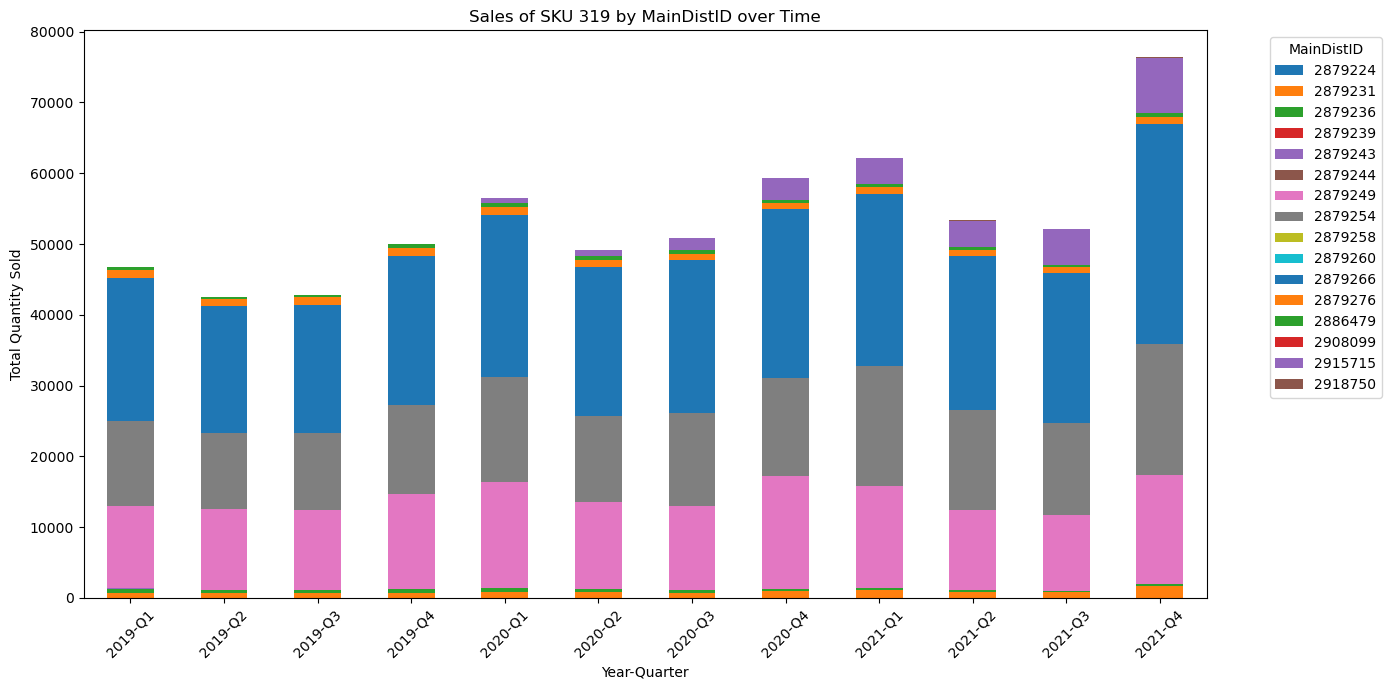

In [163]:
for sku_id in all_sku_ids:
    sku_data = main_dist_data_quarterly[main_dist_data_quarterly['SkuID'] == sku_id]
    sku_data.set_index(['Year', 'Quarter'], inplace=True)
    plot_sku_main_dist(sku_id)

In [164]:
sku_319 = main_dist_data_quarterly[main_dist_data_quarterly['SkuID'] == "319"]
sku_319

Year  Quarter MainDistID SkuID  TotalQuantity
0    2019        1    2879231   319            763
1    2019        1    2879236   319            554
2    2019        1    2879243   319            149
3    2019        1    2879244   319              8
4    2019        1    2879249   319          11532
..    ...      ...        ...   ...            ...
129  2021        4    2879266   319          31130
130  2021        4    2879276   319            984
131  2021        4    2886479   319            461
132  2021        4    2915715   319           7853
133  2021        4    2918750   319             60

[134 rows x 5 columns]

### Is there any Trend, Seasonality, Randomness, Slighlty Increasing Trend, or Decreasing Trend in the data?

SKU 319


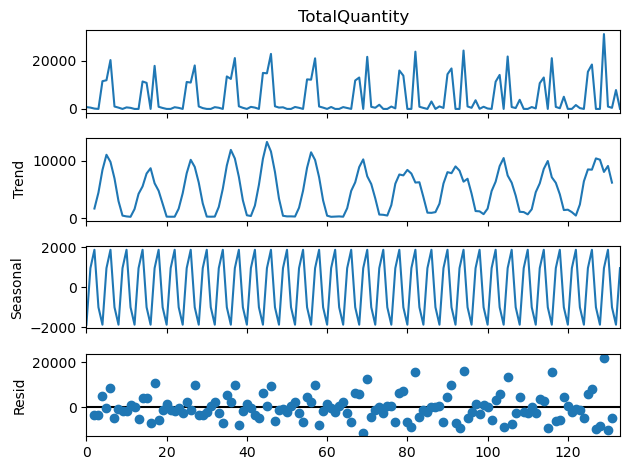

In [165]:
from statsmodels.tsa.seasonal import seasonal_decompose

for sku_id in all_sku_ids:
    print(f'SKU {sku_id}')
    sku_data = main_dist_data_quarterly[main_dist_data_quarterly['SkuID'] == sku_id]
    result = seasonal_decompose(sku_data['TotalQuantity'], model='additive', period=4)
    result.plot()
    plt.show()

# Forecasting

### Evaluation Metrics
- Mean Absolute Percentage Error (MAPE)
- Mean Squared Error (MSE)
- Root Mean Squared Error (RMSE)
- Bias


In [166]:
def calculate_metrics(actual, forecasted):
    mape = (np.abs((forecasted - actual) / actual).replace([np.inf, -np.inf], np.nan).dropna()).mean()
    mse = ((forecasted - actual) ** 2).mean()
    rmse = mse ** 0.5
    bias = (forecasted - actual).mean()
    return mape, mse, rmse, bias

## Naive - Moving Average - Exponential Smoothing Forecasting Methods

### Quarterly Sales Analysis and Forecasting 

#### Training and Testing Data
- Training Data: 2019-Q1 to 2020-Q4
- Testing Data: 2021-Q1 to 2021-Q4

```python
train = sku_data['TotalQuantity'][:-4]
test = sku_data['TotalQuantity'][-4:]
```

In [167]:
import numpy as np
from statsmodels.tsa.holtwinters import ExponentialSmoothing

def NaiveForecast(train_data, forecast_periods=4):
    forecast = train_data[-1:].values[0]
    return np.array([forecast] * forecast_periods)

def MovingAverageForecast(train_data, forecast_periods=4):
    forecast = np.array([train_data.mean()] * forecast_periods)
    return forecast

def ExponentialSmoothingForecast(train_data, forecast_periods=4):
    exp_smoothing = ExponentialSmoothing(train_data.squeeze(), seasonal='add', seasonal_periods=4, trend='add').fit()
    forecast = exp_smoothing.forecast(forecast_periods)
    return forecast


In [168]:
def plot_forecasts_and_calculate_metrics_quarterly(sku_id):
    df = main_dist_data_quarterly[main_dist_data_quarterly['SkuID'] == sku_id]
    df['Date'] = df.apply(lambda row: f"{row['Year']}-Q{row['Quarter']}", axis=1)
    df['Date'] = pd.PeriodIndex(df['Date'], freq='Q').to_timestamp()
    df.set_index('Date', inplace=True)
    df = df.drop(columns=['Year', 'Quarter'])
    
    # Ensure the series is of numeric type
    df = df.astype(float)
    
    metrics = {}
    
    for main_dist_id in df['MainDistID'].unique():
        main_dist_data = df[df['MainDistID'] == main_dist_id]['TotalQuantity']
        train = main_dist_data[:-4]
        test = main_dist_data[-4:]
        
        # Check if the data is not enough
        if len(test) < 4:
            print(f"Not enough data for testing forecasting for MainDistID {main_dist_id}. Skipping.")
            continue
            
        if len(train) < 8:
            print(f"Not enough data for training forecasting for MainDistID {main_dist_id}. Skipping.")
            continue
        
        # Forecasting methods
        naive_forecast = NaiveForecast(train, forecast_periods=4)
        moving_avg_forecast = MovingAverageForecast(train, forecast_periods=4)
        ses_forecast = ExponentialSmoothingForecast(train, forecast_periods=4)
        
        # Calculate metrics
        naive_mape, naive_mse, naive_rmse, naive_bias = calculate_metrics(test, naive_forecast)
        moving_avg_mape, moving_avg_mse, moving_avg_rmse, moving_avg_bias = calculate_metrics(test, moving_avg_forecast)
        ses_mape, ses_mse, ses_rmse, ses_bias = calculate_metrics(test, ses_forecast)
        
        metrics[main_dist_id] = {
            'Naive': {'MAPE': naive_mape, 'MSE': naive_mse, 'RMSE': naive_rmse, 'Bias': naive_bias},
            'Moving Average': {'MAPE': moving_avg_mape, 'MSE': moving_avg_mse, 'RMSE': moving_avg_rmse, 'Bias': moving_avg_bias},
            'Exponential Smoothing': {'MAPE': ses_mape, 'MSE': ses_mse, 'RMSE': ses_rmse, 'Bias': ses_bias},
        }
        
        # Plotting
        plt.figure(figsize=(14, 7))
        plt.plot(train.index, train, label='Original (Train)')
        plt.plot(test.index, test, label='Original (Test)', color='gray')
        plt.plot(test.index, naive_forecast, label='Naive Forecast', linestyle='--')
        plt.plot(test.index, moving_avg_forecast, label='Moving Average Forecast', linestyle='--')
        plt.plot(test.index, ses_forecast, label='Exponential Smoothing Forecast', linestyle='--')
        
        plt.title(f'Sales Forecast for SKU {sku_id} - MainDistID {main_dist_id}')
        plt.xlabel('Year-Quarter')
        plt.ylabel('Total Quantity Sold')
        plt.legend()
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
        
    metrics_df = pd.DataFrame.from_dict({(i,j): metrics[i][j] 
                             for i in metrics.keys() 
                             for j in metrics[i].keys()},
                            orient='index')
    metrics_df.index = metrics_df.index.rename(['MainDistID', 'Method'])
    metrics_df.index = metrics_df.index.set_levels(metrics_df.index.levels[0].astype(int), level=0)
        
    return metrics_df

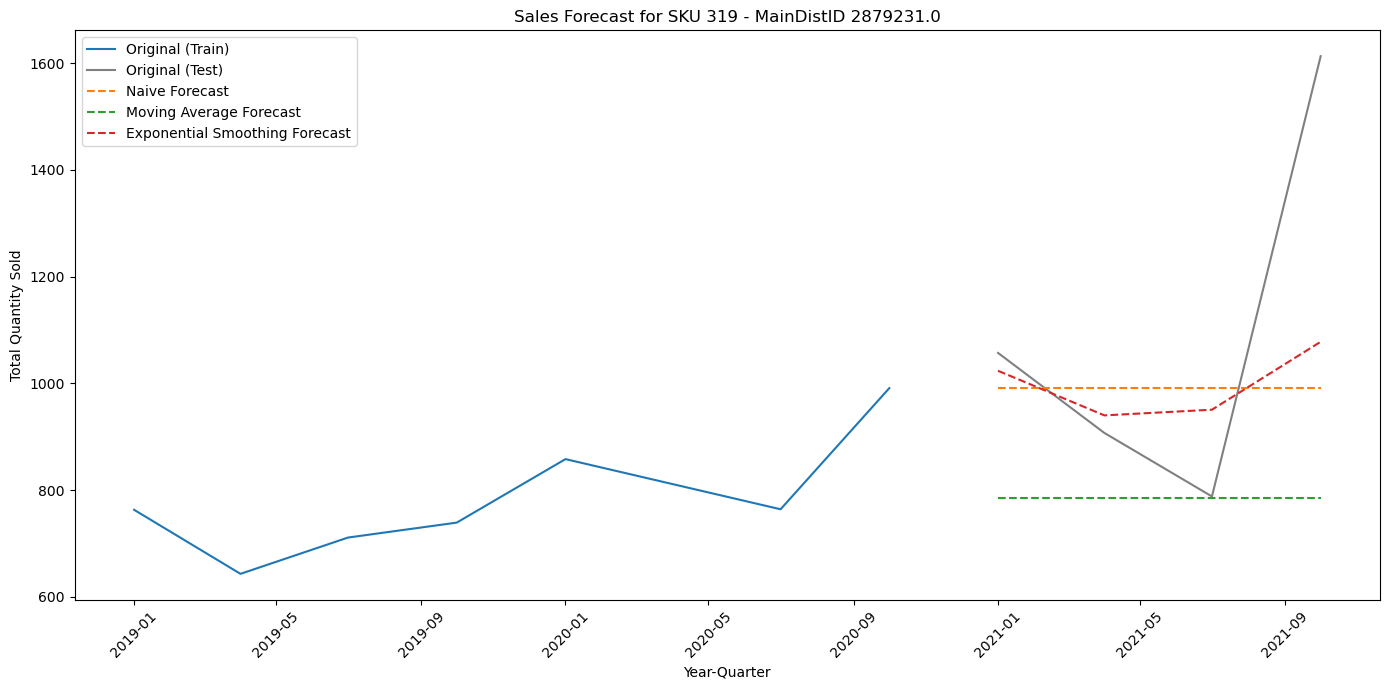

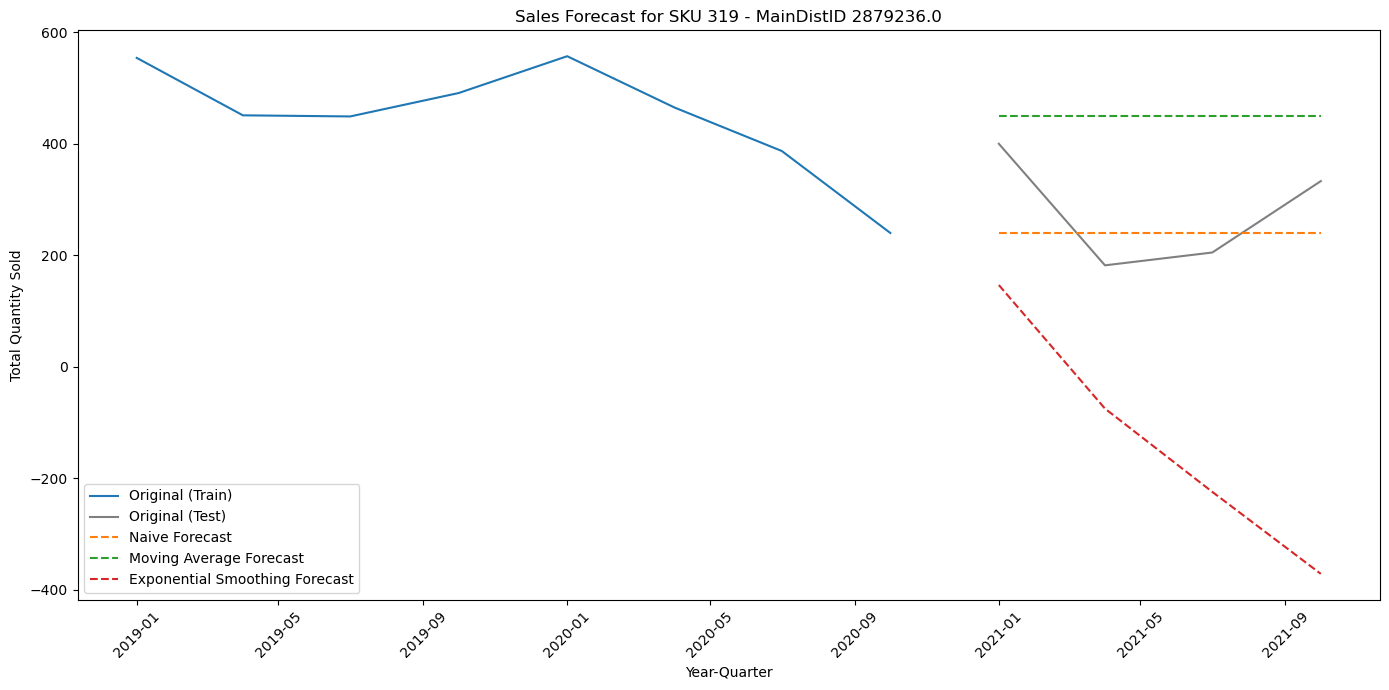

Not enough data for testing forecasting for MainDistID 2879243.0. Skipping.
Not enough data for training forecasting for MainDistID 2879244.0. Skipping.


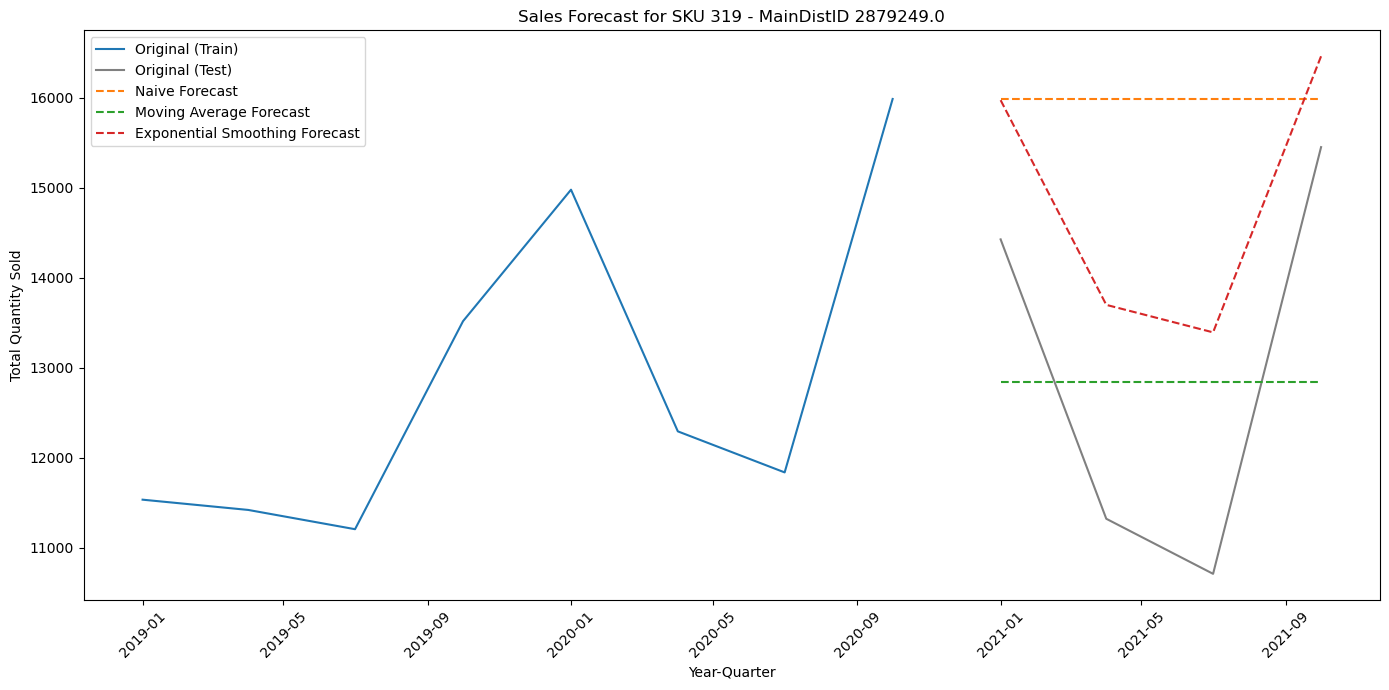

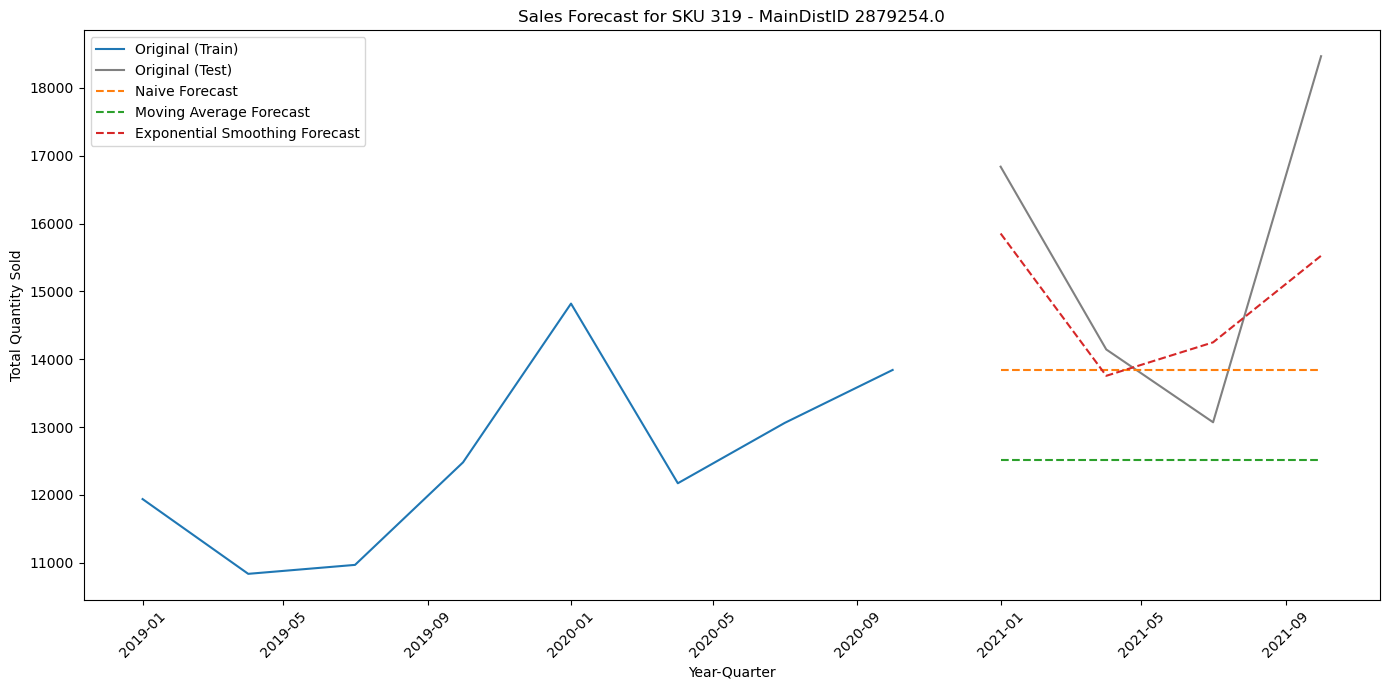

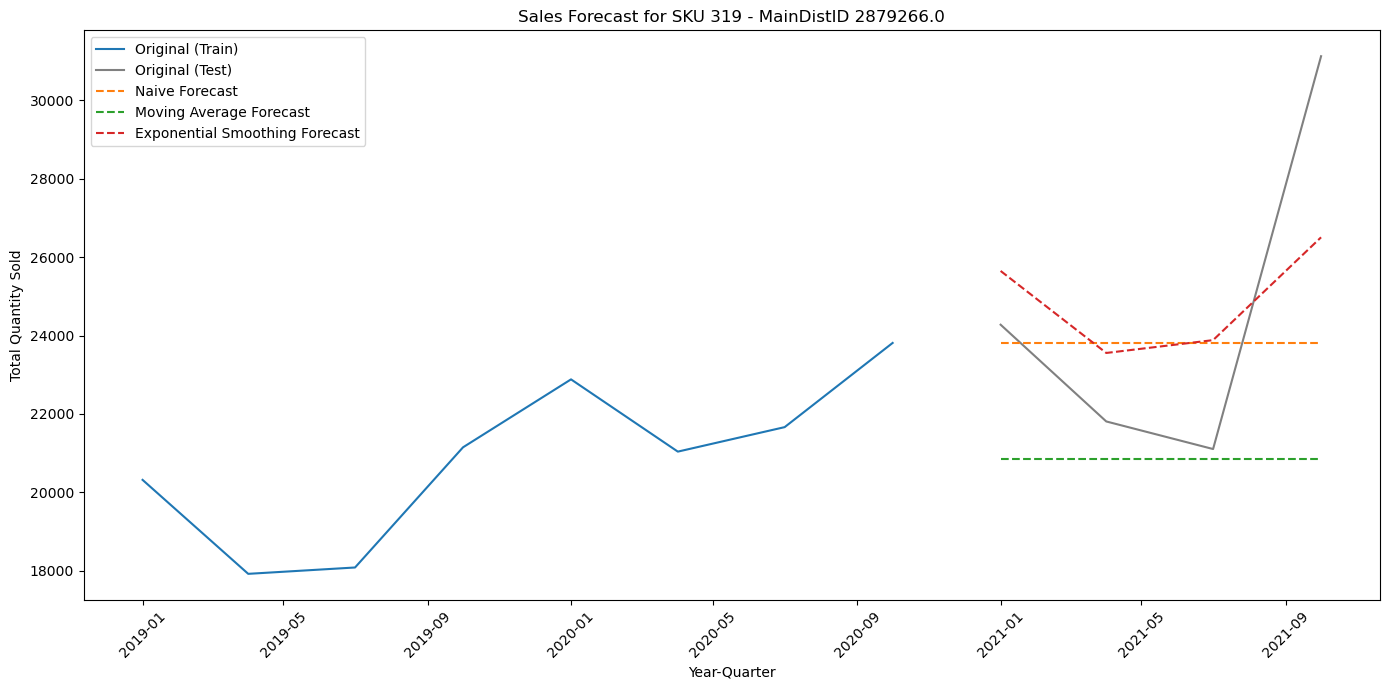

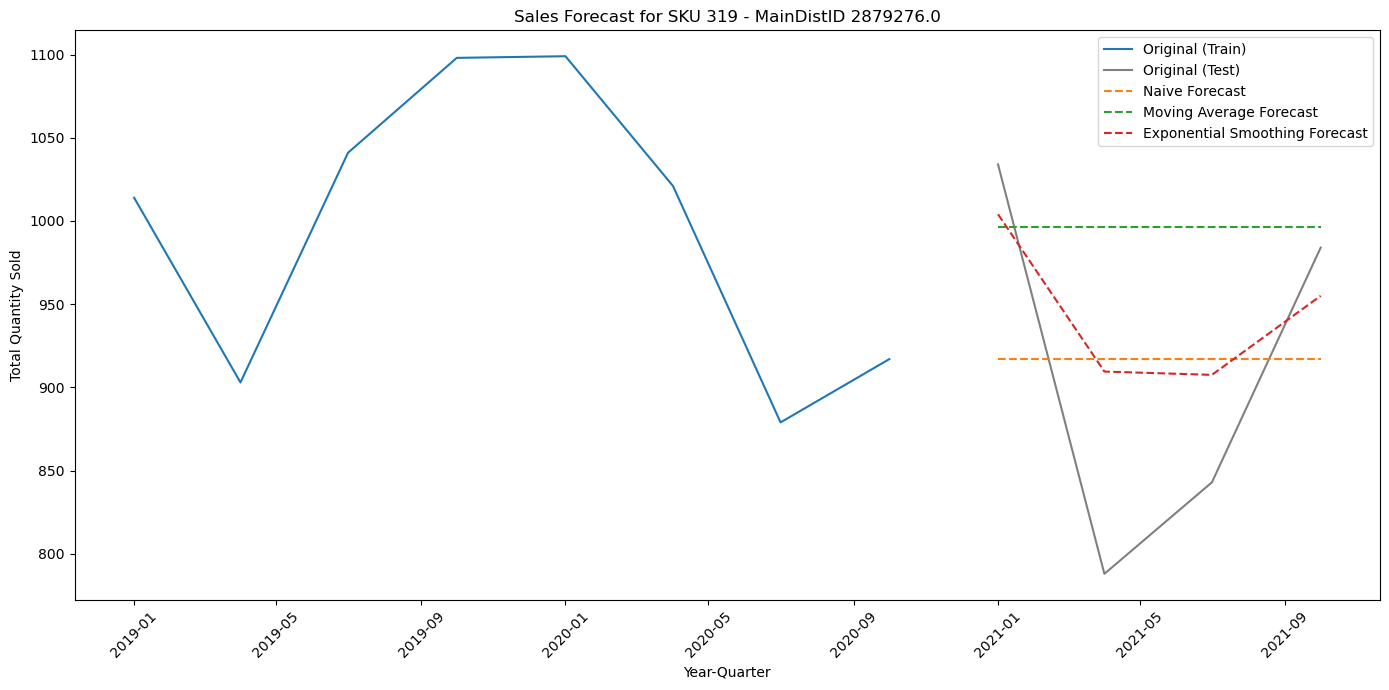

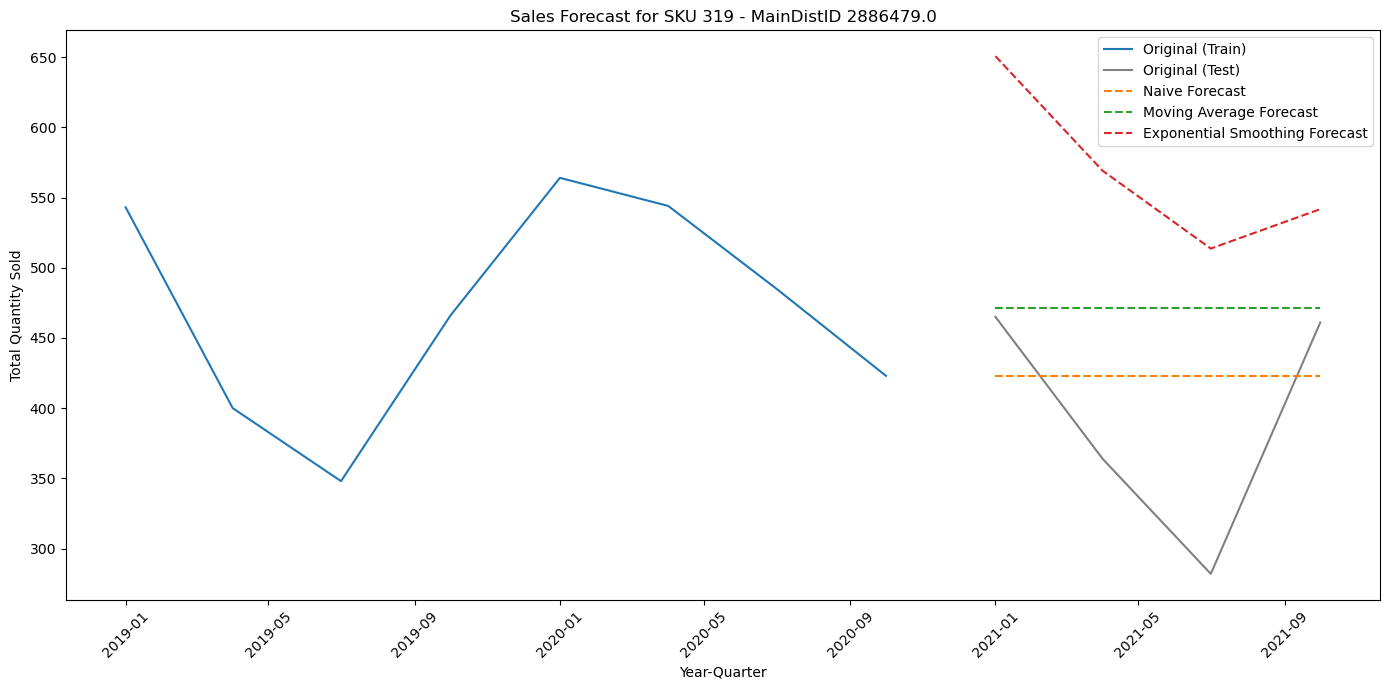

Not enough data for training forecasting for MainDistID 2908099.0. Skipping.
Not enough data for testing forecasting for MainDistID 2879239.0. Skipping.
Not enough data for training forecasting for MainDistID 2879260.0. Skipping.
Not enough data for training forecasting for MainDistID 2879224.0. Skipping.
Not enough data for training forecasting for MainDistID 2915715.0. Skipping.
Not enough data for training forecasting for MainDistID 2918750.0. Skipping.
Not enough data for training forecasting for MainDistID 2879258.0. Skipping.


In [169]:
metrics_df_quarterly = plot_forecasts_and_calculate_metrics_quarterly('319')

In [170]:
metrics_df_quarterly

MAPE           MSE         RMSE  \
MainDistID Method                                                       
2879231    Naive                  0.199571  1.098762e+05   331.475866   
           Moving Average         0.227244  1.936152e+05   440.017329   
           Exponential Smoothing  0.151515  7.874627e+04   280.617664   
2879236    Naive                  0.292173  9.709500e+03    98.536795   
           Moving Average         0.783024  3.675506e+04   191.716099   
           Exponential Smoothing  1.563408  2.025937e+05   450.104086   
2879249    Naive                  0.261878  1.307722e+07  3616.244495   
           Moving Average         0.153071  4.041776e+06  2010.416861   
           Exponential Smoothing  0.158275  4.064582e+06  2016.080954   
2879254    Naive                  0.127161  7.760759e+06  2785.813930   
           Moving Average         0.184168  1.426638e+07  3777.085748   
           Exponential Smoothing  0.083824  2.789254e+06  1670.106115   
2879266    Naive                  0.118600  1.627600e+07  4034.352302   
           Moving Average         0.131516  2.954023e+07  5435.092111   
           Exponential Smoothing  0.104200  8.505346e+06  2916.392709   
2879276    Naive                  0.108182  1.007375e+04   100.368073   
           Moving Average         0.123913  1.714925e+04   130.955145   
           Exponential Smoothing  0.072301  5.168477e+03    71.892122   
2886479    Naive                  0.208710  6.642500e+03    81.501534   
           Moving Average         0.251349  1.192439e+04   109.198858   
           Exponential Smoothing  0.489801  3.417495e+04   184.864687   

                                         Bias  
MainDistID Method                              
2879231    Naive                  -100.250000  
           Moving Average         -306.250000  
           Exponential Smoothing   -93.271409  
2879236    Naive                   -40.000000  
           Moving Average          169.250000  
           Exponential Smoothing  -410.931821  
2879249    Naive                  3008.750000  
           Moving Average         -130.875000  
           Exponential Smoothing  1904.042603  
2879254    Naive                 -1787.750000  
           Moving Average        -3114.750000  
           Exponential Smoothing  -784.055170  
2879266    Naive                  -767.500000  
           Moving Average        -3722.000000  
           Exponential Smoothing   319.320013  
2879276    Naive                     4.750000  
           Moving Average           84.250000  
           Exponential Smoothing    31.791544  
2886479    Naive                    30.000000  
           Moving Average           78.625000  
           Exponential Smoothing   175.773693

In [171]:
metrics_df_quarterly.loc[(2879231, 'Moving Average')]

MAPE         0.227244
MSE     193615.250000
RMSE       440.017329
Bias      -306.250000
Name: (2879231, Moving Average), dtype: float64

### Monthly Sales Analysis and Forecasting 

In [172]:
main_dist_data_monthly = data.copy()
main_dist_data_monthly['Year'] = main_dist_data_monthly['Date'].dt.year
main_dist_data_monthly['Month'] = main_dist_data_monthly['Date'].dt.month

main_dist_data_monthly = main_dist_data_monthly.groupby(['Year', 'Month', 'MainDistID', 'SkuID']).agg({'TotalQuantity': 'sum'}).reset_index()
main_dist_data_monthly

Year  Month MainDistID SkuID  TotalQuantity
0    2019      1    2879231   319            332
1    2019      1    2879236   319            219
2    2019      1    2879243   319            128
3    2019      1    2879244   319              3
4    2019      1    2879249   319           3988
..    ...    ...        ...   ...            ...
338  2021     12    2879266   319          10467
339  2021     12    2879276   319            318
340  2021     12    2886479   319            196
341  2021     12    2915715   319           3117
342  2021     12    2918750   319             44

[343 rows x 5 columns]

In [173]:
def plot_sku_main_dist_monthly(sku_id):
    sku_data = main_dist_data_monthly[main_dist_data_monthly['SkuID'] == sku_id]
    sku_data['YearMonth'] = sku_data['Year'].astype(str) + '-' + sku_data['Month'].astype(str).str.zfill(2)
    pivot_table = sku_data.pivot(index='YearMonth', columns='MainDistID', values='TotalQuantity')
    pivot_table.plot(kind='bar', stacked=True, figsize=(14, 7))
    plt.title(f'Sales of SKU {sku_id} by MainDistID over Time')
    plt.xlabel('Year-Month')
    plt.ylabel('Total Quantity Sold')
    plt.legend(title='MainDistID', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

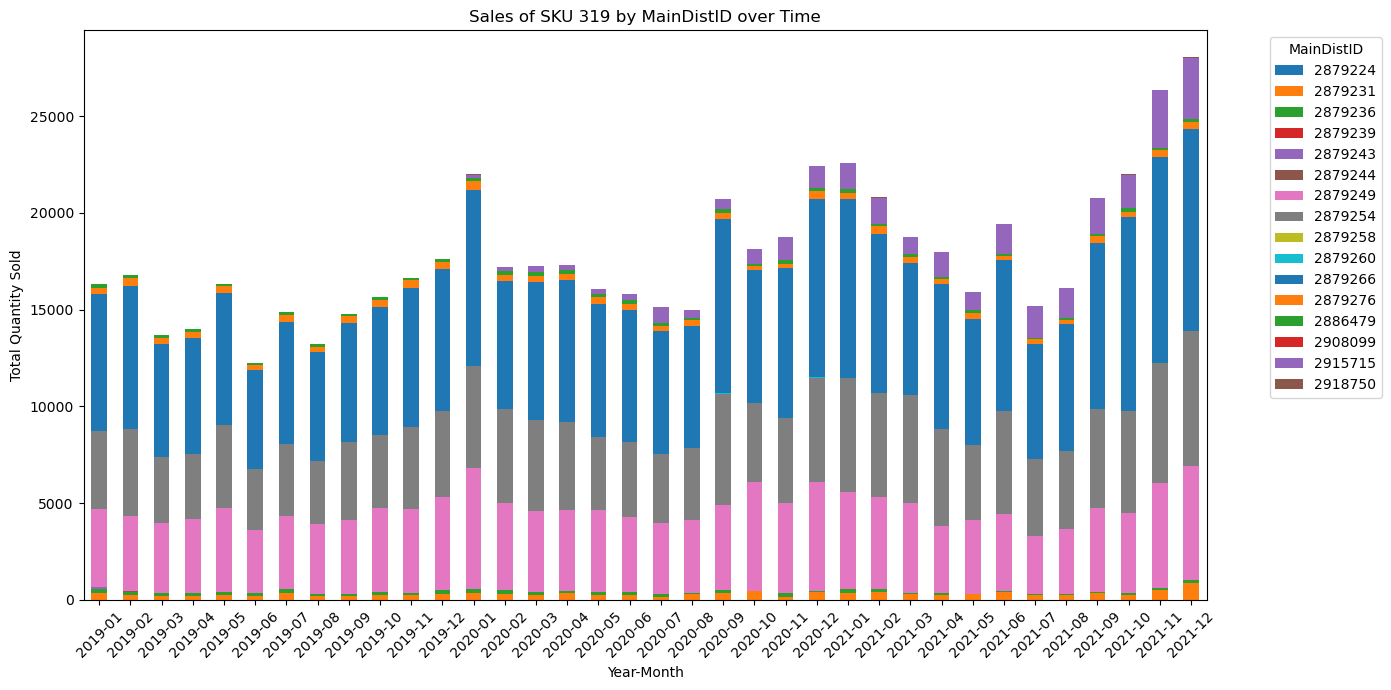

In [174]:
for sku_id in all_sku_ids:
    sku_data = main_dist_data_monthly[main_dist_data_monthly['SkuID'] == sku_id]
    sku_data.set_index(['Year', 'Month'], inplace=True)
    plot_sku_main_dist_monthly(sku_id)

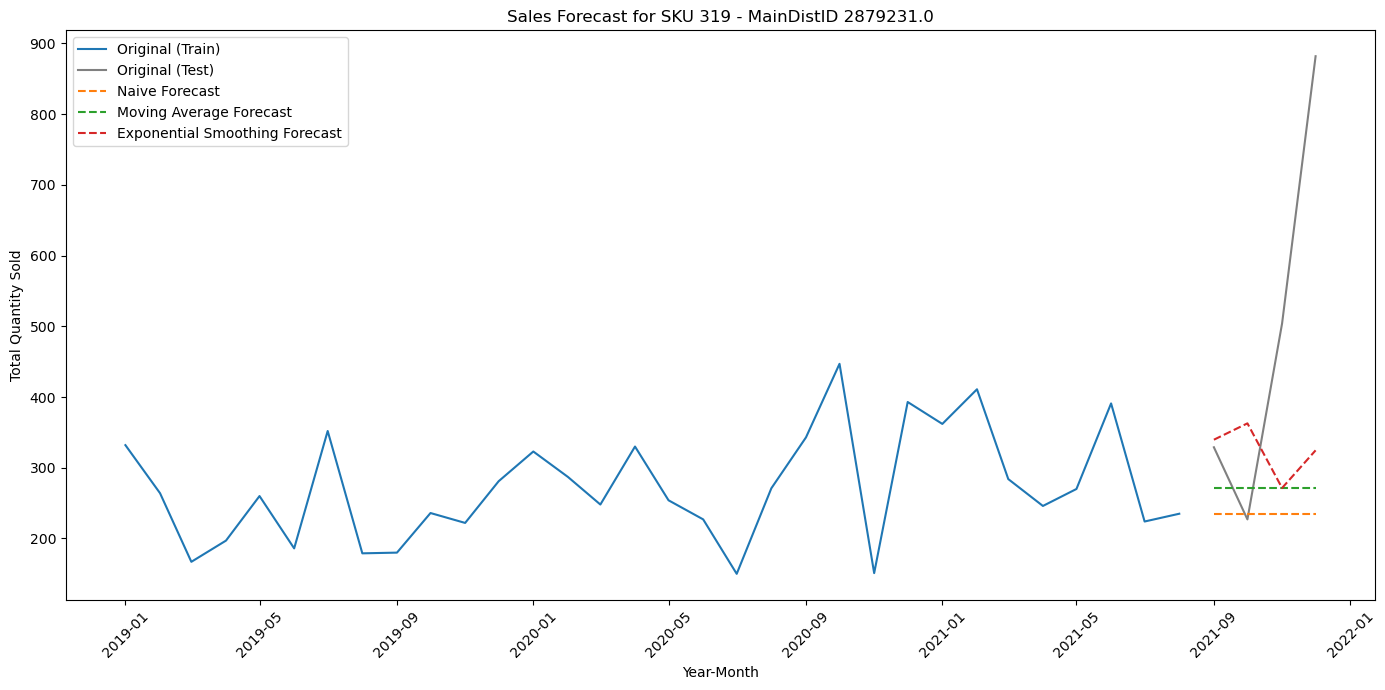

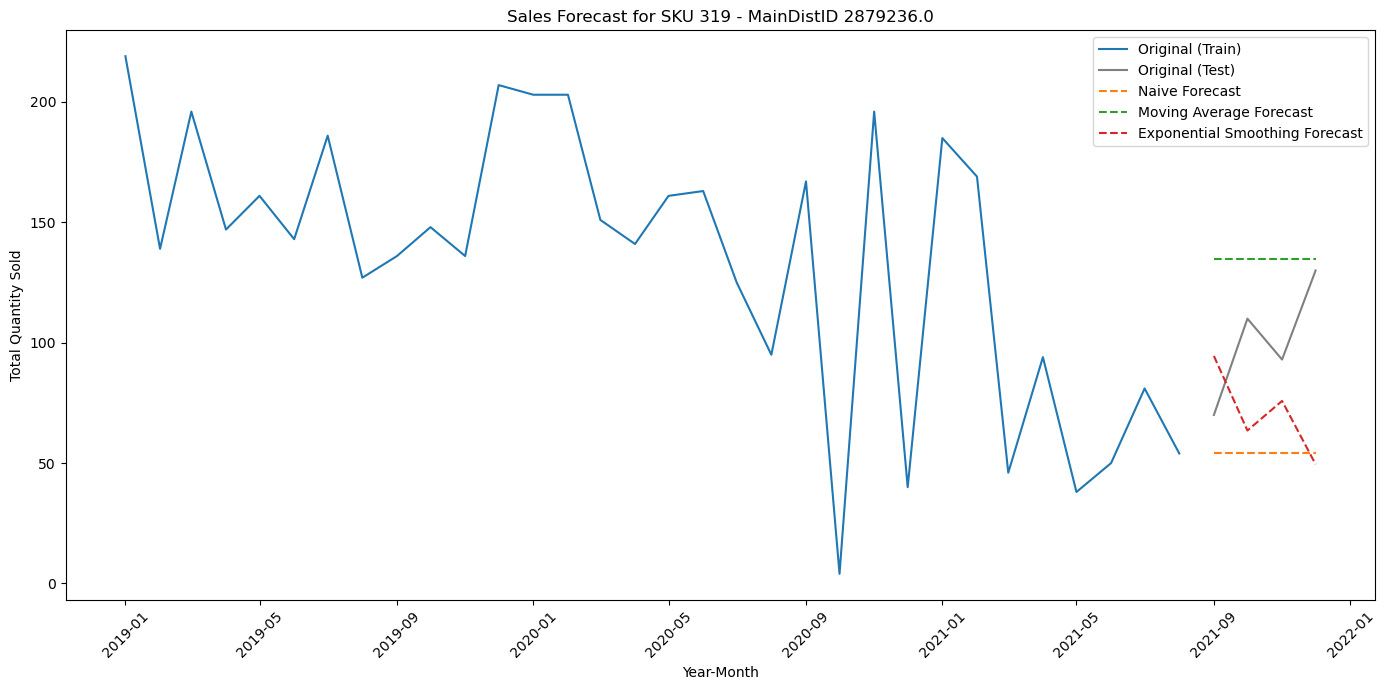

Not enough data for testing forecasting for MainDistID 2879243.0. Skipping.


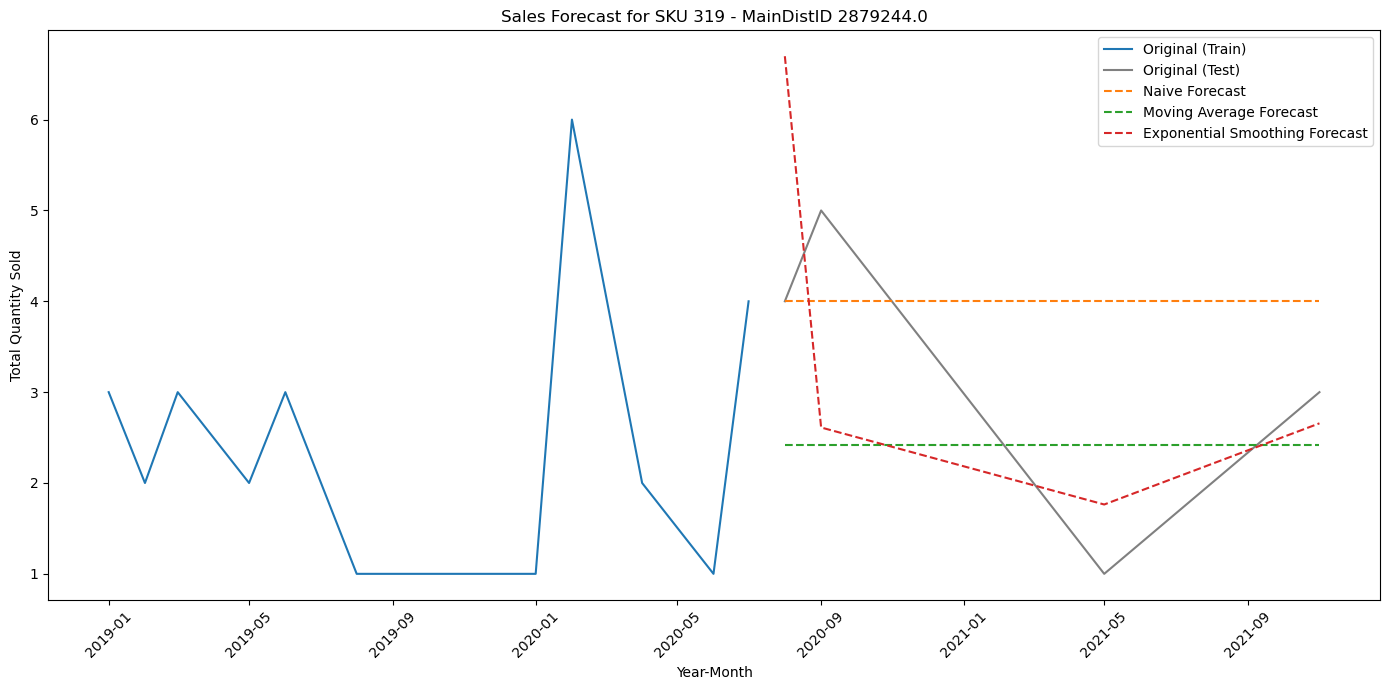

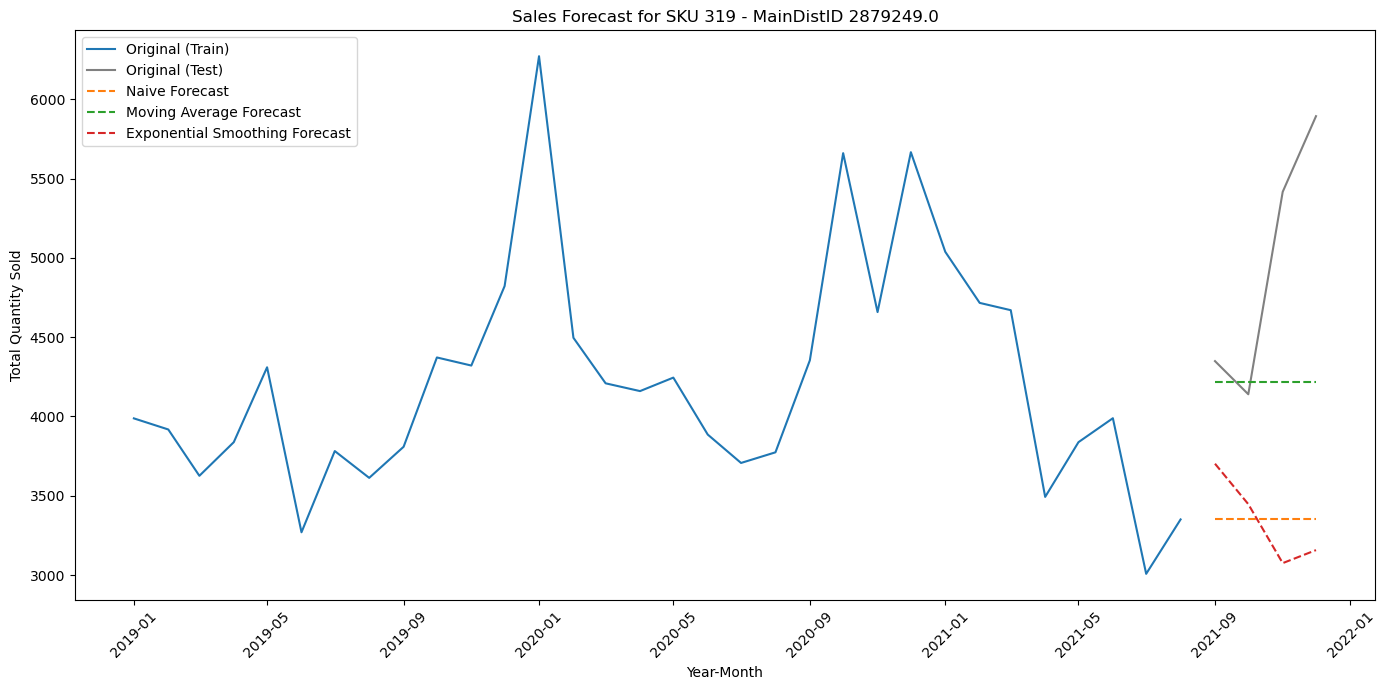

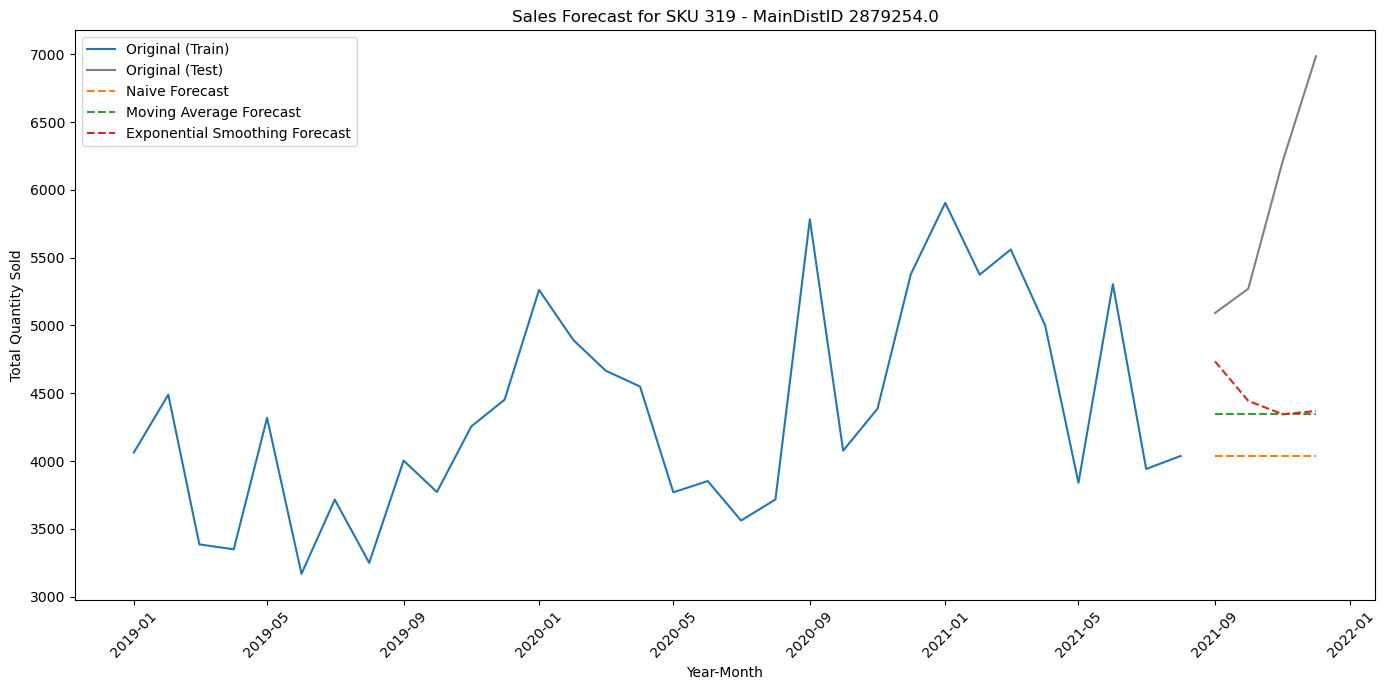

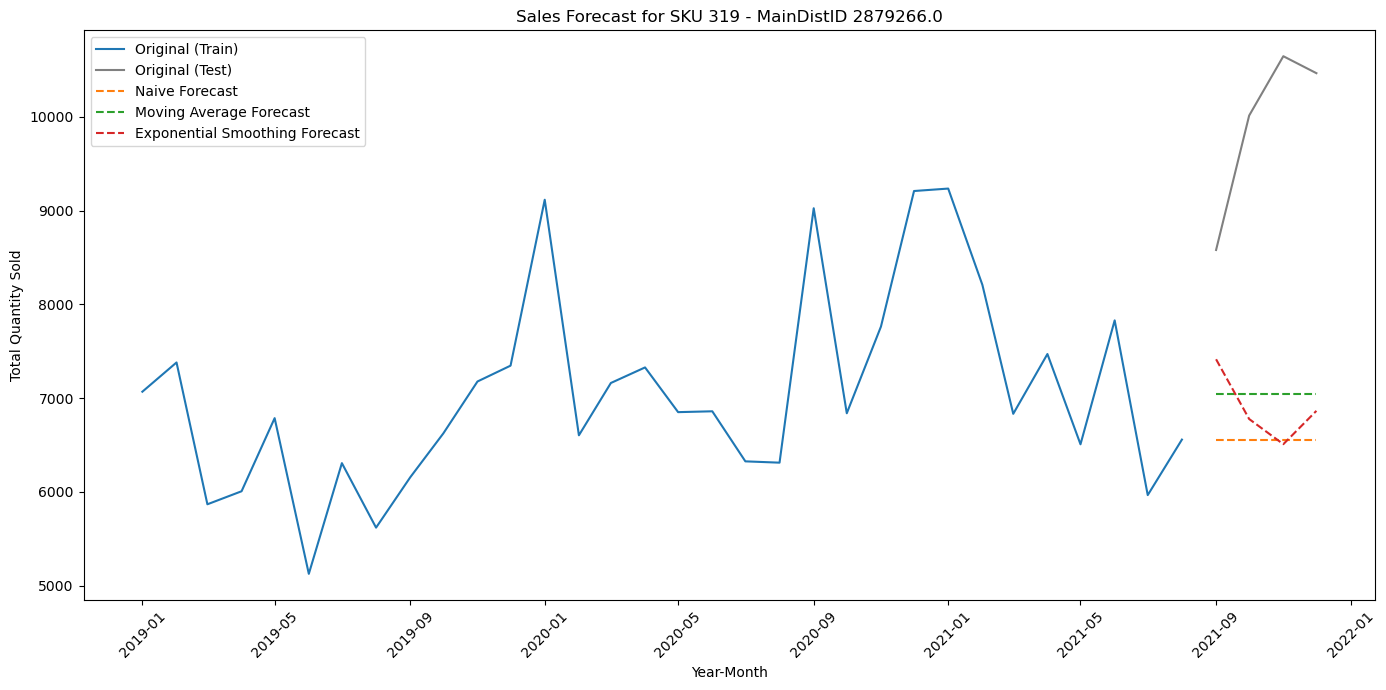

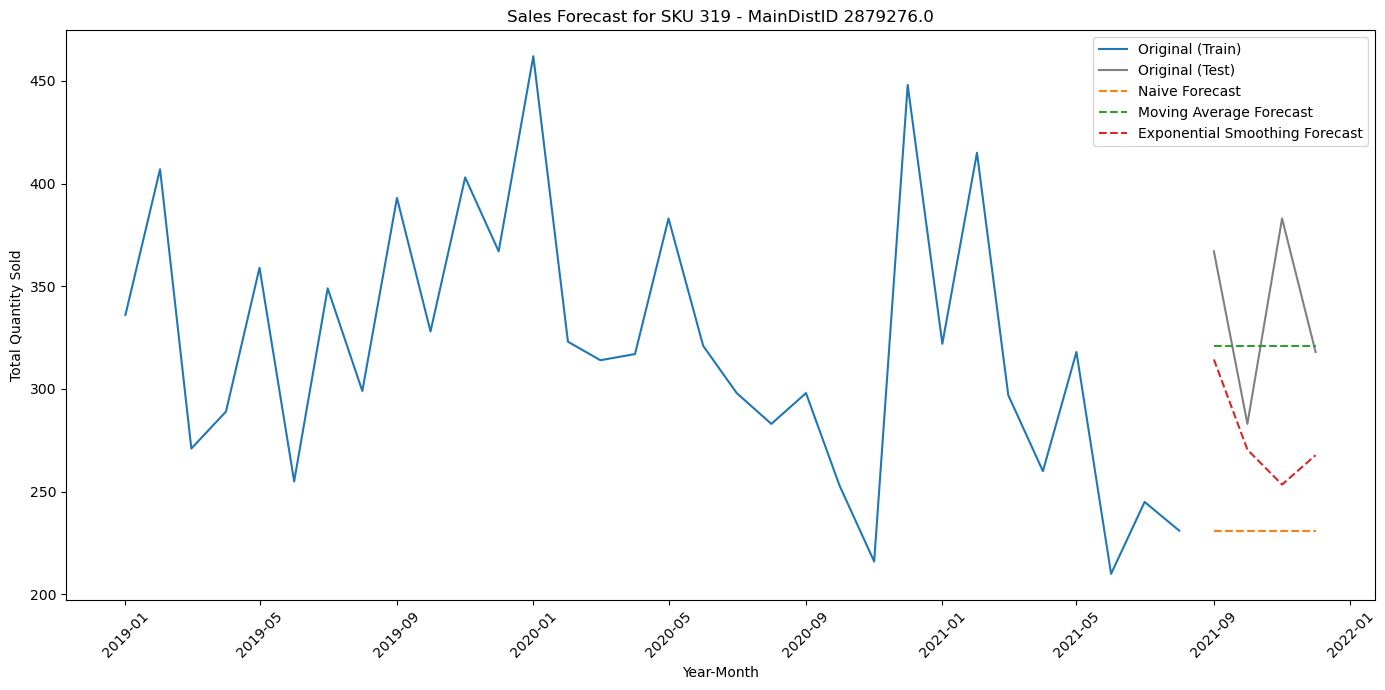

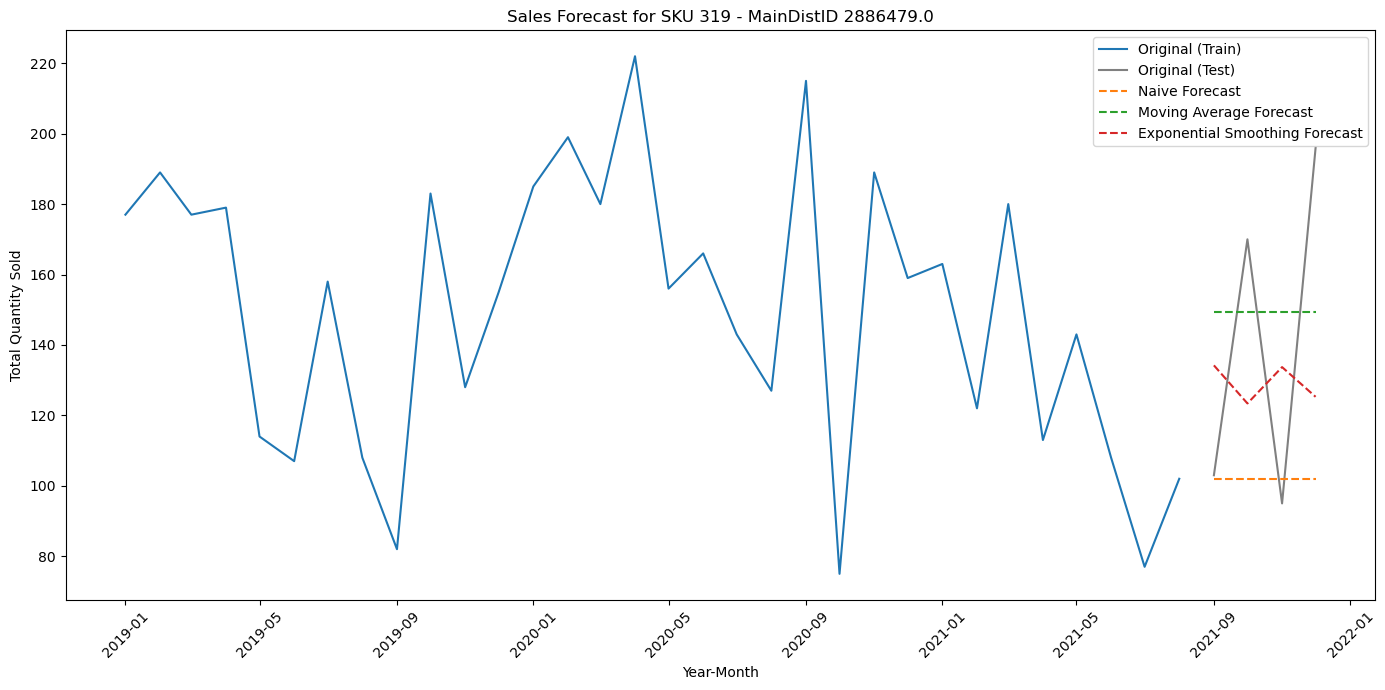

Not enough data for training forecasting for MainDistID 2908099.0. Skipping.
Not enough data for testing forecasting for MainDistID 2879239.0. Skipping.
Not enough data for training forecasting for MainDistID 2879260.0. Skipping.


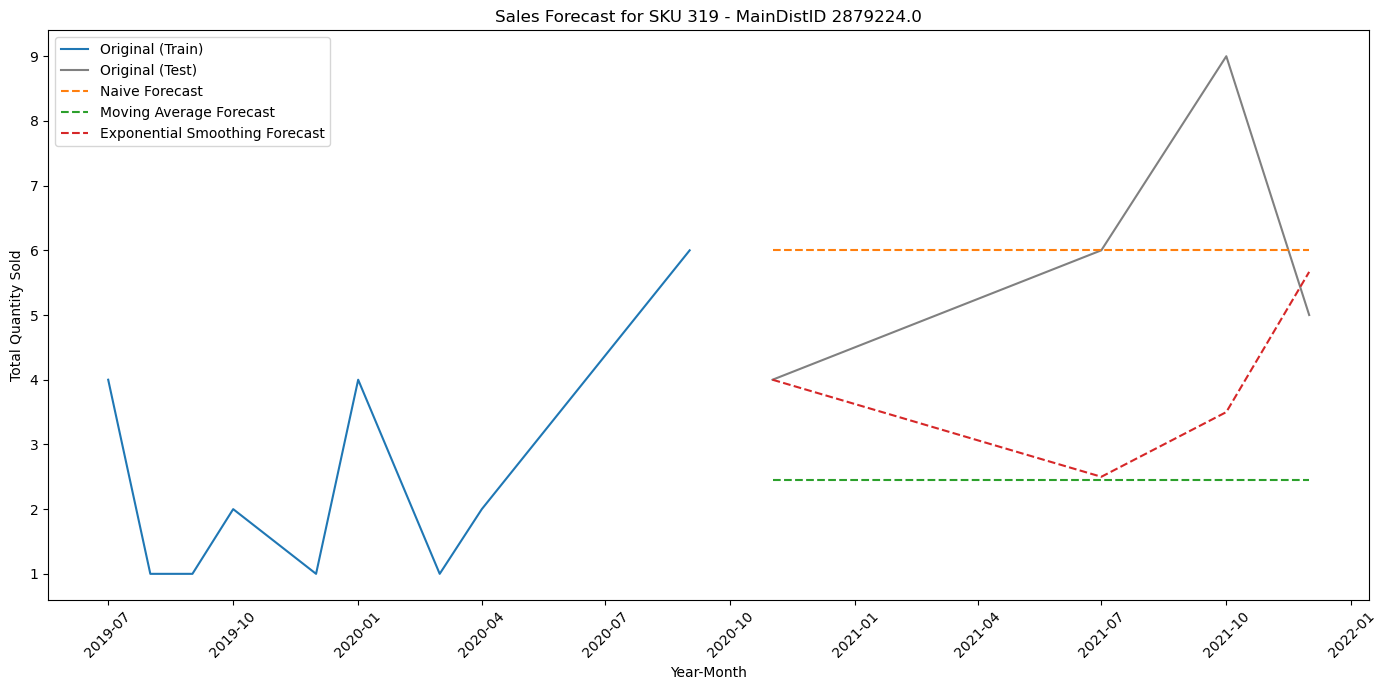

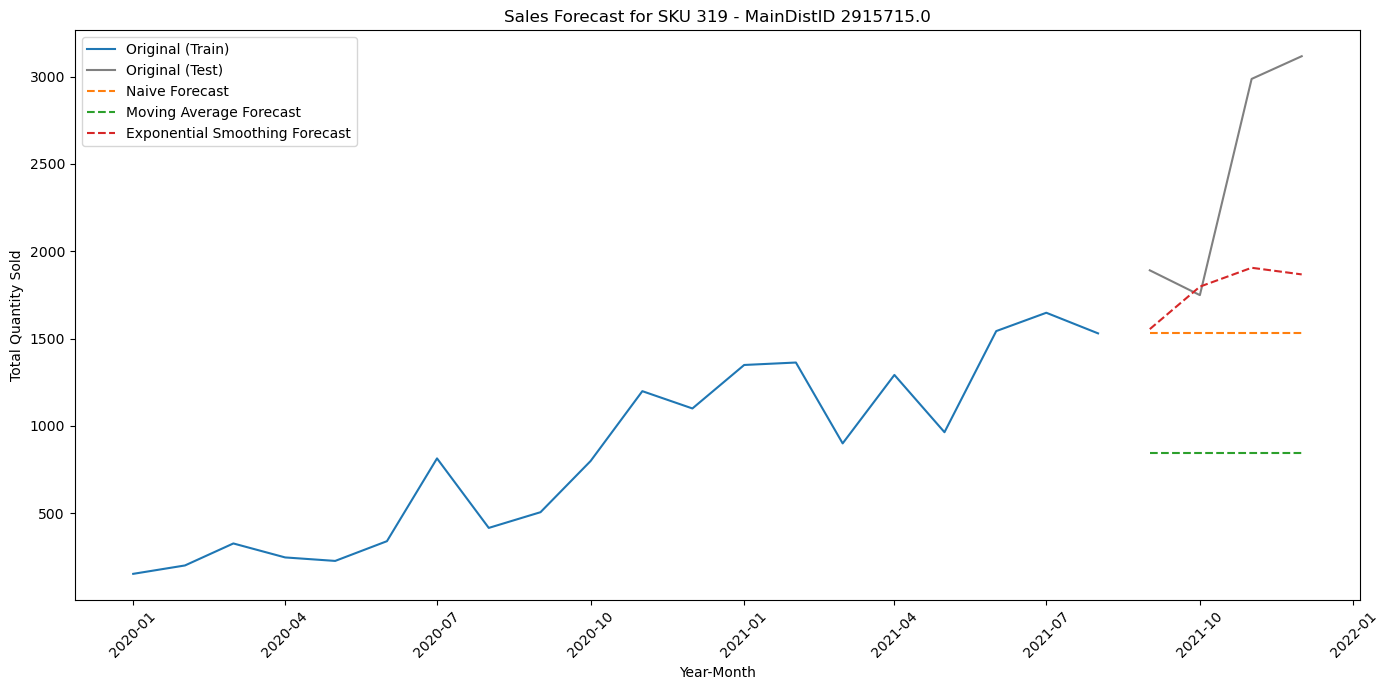

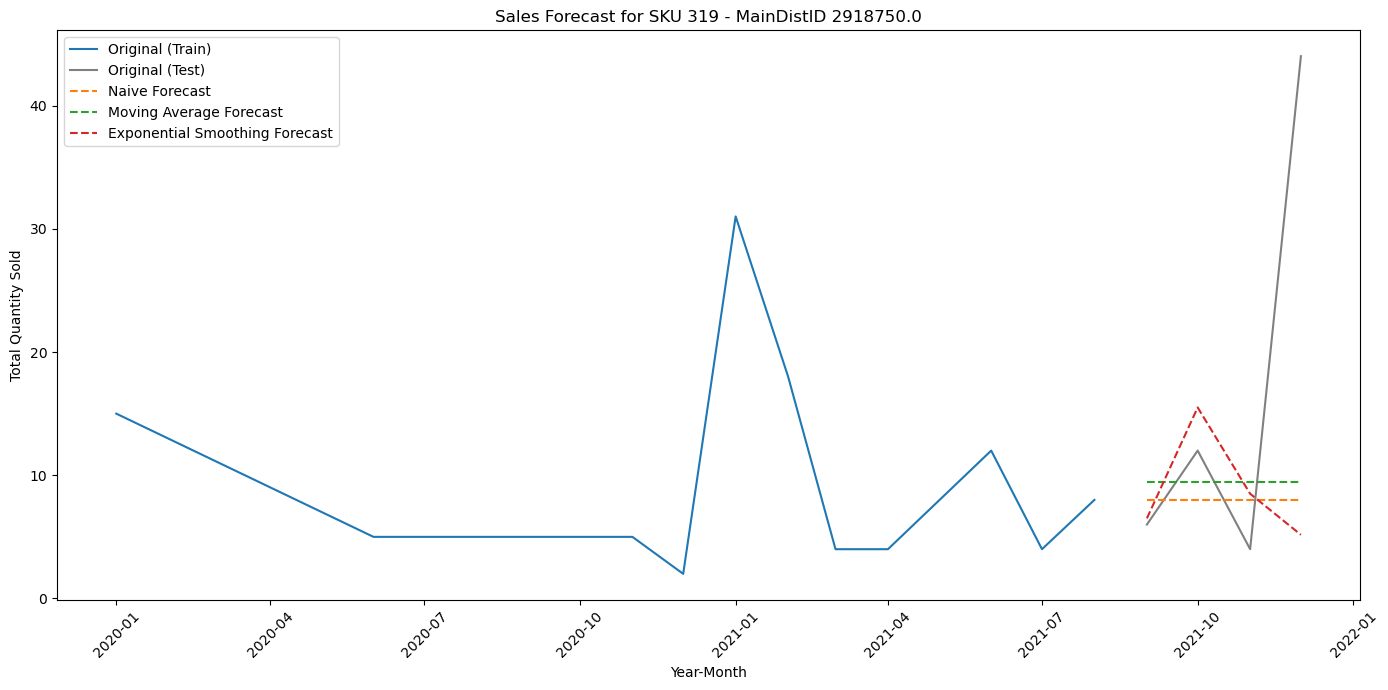

Not enough data for training forecasting for MainDistID 2879258.0. Skipping.


In [175]:

def plot_forecasts_and_calculate_metrics_monthly(sku_id):
    df = main_dist_data_monthly[main_dist_data_monthly['SkuID'] == sku_id]
    df['Date'] = df.apply(lambda row: f"{row['Year']}-{row['Month']}", axis=1)
    df['Date'] = pd.PeriodIndex(df['Date'], freq='M').to_timestamp()
    df.set_index('Date', inplace=True)
    df = df.drop(columns=['Year', 'Month'])
    
    # Ensure the series is of numeric type
    df = df.astype(float)
    
    metrics = {}
    
    for main_dist_id in df['MainDistID'].unique():
        main_dist_data = df[df['MainDistID'] == main_dist_id]['TotalQuantity']
        train = main_dist_data[:-4]
        test = main_dist_data[-4:]
        
        # Check if the data is not enough
        if len(test) < 4:
            print(f"Not enough data for testing forecasting for MainDistID {main_dist_id}. Skipping.")
            continue
            
        if len(train) < 8:
            print(f"Not enough data for training forecasting for MainDistID {main_dist_id}. Skipping.")
            continue
        
        # Forecasting methods
        naive_forecast = NaiveForecast(train, forecast_periods=4)
        moving_avg_forecast = MovingAverageForecast(train, forecast_periods=4)
        ses_forecast = ExponentialSmoothingForecast(train, forecast_periods=4)
        
        # Calculate metrics
        naive_mape, naive_mse, naive_rmse, naive_bias = calculate_metrics(test, naive_forecast)
        moving_avg_mape, moving_avg_mse, moving_avg_rmse, moving_avg_bias = calculate_metrics(test, moving_avg_forecast)
        ses_mape, ses_mse, ses_rmse, ses_bias = calculate_metrics(test, ses_forecast)
        
        metrics[main_dist_id] = {
            'Naive': {'MAPE': naive_mape, 'MSE': naive_mse, 'RMSE': naive_rmse, 'Bias': naive_bias},
            'Moving Average': {'MAPE': moving_avg_mape, 'MSE ': moving_avg_mse, 'RMSE': moving_avg_rmse, 'Bias': moving_avg_bias},
            'Exponential Smoothing': {'MAPE': ses_mape, 'MSE': ses_mse, 'RMSE': ses_rmse, 'Bias': ses_bias}
        }
        
        # Plotting
        plt.figure(figsize=(14, 7))
        plt.plot(train.index, train, label='Original (Train)')
        plt.plot(test.index, test, label='Original (Test)', color='gray')
        plt.plot(test.index, naive_forecast, label='Naive Forecast', linestyle='--')
        plt.plot(test.index, moving_avg_forecast, label='Moving Average Forecast', linestyle='--')
        plt.plot(test.index, ses_forecast, label='Exponential Smoothing Forecast', linestyle='--')
        
        plt.title(f'Sales Forecast for SKU {sku_id} - MainDistID {main_dist_id}')
        plt.xlabel('Year-Month')
        plt.ylabel('Total Quantity Sold')
        plt.legend()
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
        
    metrics_df = pd.DataFrame.from_dict({(i,j): metrics[i][j]
                                for i in metrics.keys()
                                for j in metrics[i].keys()},
                                orient='index')
    metrics_df.index = metrics_df.index.rename(['MainDistID', 'Method'])
    metrics_df.index = metrics_df.index.set_levels(metrics_df.index.levels[0].astype(int), level=0)
    
    return metrics_df

metrics_df_monthly = plot_forecasts_and_calculate_metrics_monthly('319')

In [176]:
metrics_df_monthly

MAPE           MSE         RMSE  \
MainDistID Method                                                       
2879231    Naive                  0.397062  1.249675e+05   353.507426   
           Moving Average         0.380868           NaN   328.348663   
           Exponential Smoothing  0.431051  9.583100e+04   309.565819   
2879236    Naive                  0.435408  2.672250e+03    51.693810   
           Moving Average         0.408539           NaN    40.503870   
           Exponential Smoothing  0.394043  2.383568e+03    48.821795   
2879244    Naive                  0.883333  2.750000e+00     1.658312   
           Moving Average         0.630903           NaN     1.697629   
           Exponential Smoothing       NaN           NaN          NaN   
2879249    Naive                  0.308174  3.086128e+06  1756.738028   
           Moving Average         0.138915           NaN  1035.097537   
           Exponential Smoothing  0.303089  3.464623e+06  1861.349652   
2879254    Naive                  0.303170  4.009486e+06  2002.370033   
           Moving Average         0.249911           NaN  1720.971369   
           Exponential Smoothing  0.225432  2.782984e+06  1668.227835   
2879266    Naive                  0.334626  1.201294e+07  3465.968804   
           Moving Average         0.285092           NaN  2993.484096   
           Exponential Smoothing  0.297995  1.048658e+07  3238.298433   
2879276    Naive                  0.306192  1.296825e+04   113.878224   
           Moving Average         0.107712           NaN    43.073747   
           Exponential Smoothing  0.171007  5.557834e+03    74.550879   
2886479    Naive                  0.240746  3.377500e+03    58.116263   
           Moving Average         0.345527           NaN    43.899488   
           Exponential Smoothing  0.336362  2.411619e+03    49.108237   
2879224    Naive                  0.258333  3.500000e+00     1.870829   
           Moving Average         0.555247           NaN     4.017708   
           Exponential Smoothing       NaN           NaN          NaN   
2915715    Naive                  0.328261  1.204925e+06  1097.690758   
           Moving Average         0.628612           NaN  1706.606870   
           Exponential Smoothing  0.242173  7.115511e+05   843.534868   
2918750    Naive                  0.621212  3.330000e+02    18.248288   
           Moving Average         0.731218           NaN    17.633026   
           Exponential Smoothing       NaN           NaN          NaN   

                                         Bias          MSE   
MainDistID Method                                            
2879231    Naive                  -250.500000           NaN  
           Moving Average         -213.531250  1.078128e+05  
           Exponential Smoothing  -160.870830           NaN  
2879236    Naive                   -46.750000           NaN  
           Moving Average           33.968750  1.640563e+03  
           Exponential Smoothing   -29.914101           NaN  
2879244    Naive                     0.750000           NaN  
           Moving Average           -0.833333  2.881944e+00  
           Exponential Smoothing          NaN           NaN  
2879249    Naive                 -1598.500000           NaN  
           Moving Average         -735.187500  1.071427e+06  
           Exponential Smoothing -1603.839226           NaN  
2879254    Naive                 -1851.750000           NaN  
           Moving Average        -1543.125000  2.961742e+06  
           Exponential Smoothing -1416.147716           NaN  
2879266    Naive                 -3369.750000           NaN  
           Moving Average        -2881.531250  8.960947e+06  
           Exponential Smoothing -3036.108751           NaN  
2879276    Naive                  -106.750000           NaN  
           Moving Average          -16.812500  1.855348e+03  
           Exponential Smoothing   -61.244069           NaN  
2886479    Naive                   -39.000000           

## Seasonal Forecasting Methods - Triple Exponential Smoothing - ARIMA - SARIMA 

### Quarterly Sales Analysis and Forecasting 

#### Training and Testing Data
- Training Data: 2019-Q1 to 2020-Q4
- Testing Data: 2021-Q1 to 2021-Q4

```python
train = sku_data['TotalQuantity'][:-4]
test = sku_data['TotalQuantity'][-4:]
```

In [177]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

def TripleExponentialSmoothingForecast(train_data, forecast_periods=4):
    triple_exp_smoothing = ExponentialSmoothing(train_data.squeeze(), seasonal='add', seasonal_periods=4, trend='add').fit()
    forecast = triple_exp_smoothing.forecast(forecast_periods)
    return forecast

def ARIMAForecast(train_data, forecast_periods=4):
    model = ARIMA(train_data, order=(1, 1, 1)).fit()
    forecast = model.forecast(steps=forecast_periods)
    return forecast

def SARIMAForecast(train_data, forecast_periods=4):
    model = SARIMAX(train_data, order=(1, 1, 1), seasonal_order=(1, 1, 1, 4))
    model_fit = model.fit(disp=False)
    forecast = model_fit.forecast(steps=forecast_periods)
    return forecast

In [178]:
def plot_seasonal_forecasts_quarterly(sku_id):
    df = main_dist_data_quarterly[main_dist_data_quarterly['SkuID'] == sku_id]
    df['Date'] = df.apply(lambda row: f"{row['Year']}-Q{row['Quarter']}", axis=1)
    df['Date'] = pd.PeriodIndex(df['Date'], freq='Q').to_timestamp()
    df.set_index('Date', inplace=True)
    df = df.drop(columns=['Year', 'Quarter'])
    
    # Ensure the series is of numeric type
    df = df.astype(float)
    
    metrics = {}
    
    for main_dist_id in df['MainDistID'].unique():
        main_dist_data = df[df['MainDistID'] == main_dist_id]['TotalQuantity']
        train = main_dist_data[:-4]
        test = main_dist_data[-4:]
        
        # Check if the data is not enough
        if len(test) < 4:
            print(f"Not enough data for testing forecasting for MainDistID {main_dist_id}. Skipping.")
            continue
            
        if len(train) < 8:
            print(f"Not enough data for training forecasting for MainDistID {main_dist_id}. Skipping.")
            continue
        
        # Forecasting methods
        triple_exp_smoothing_forecast = TripleExponentialSmoothingForecast(train, forecast_periods=4)
        arima_forecast = ARIMAForecast(train, forecast_periods=4)
        sarima_forecast = SARIMAForecast(train, forecast_periods=4)
        
        # Calculate metrics
        triple_exp_smoothing_mape, triple_exp_smoothing_mse, triple_exp_smoothing_rmse, triple_exp_smoothing_bias = calculate_metrics(test, triple_exp_smoothing_forecast)
        arima_mape, arima_mse, arima_rmse, arima_bias = calculate_metrics(test, arima_forecast)
        sarima_mape, sarima_mse, sarima_rmse, sarima_bias = calculate_metrics(test, sarima_forecast)
        
        metrics[main_dist_id] = {
            'Triple Exponential Smoothing': {'MAPE': triple_exp_smoothing_mape, 'MSE': triple_exp_smoothing_mse, 'RMSE': triple_exp_smoothing_rmse, 'Bias': triple_exp_smoothing_bias},
            'ARIMA': {'MAPE': arima_mape, 'MSE': arima_mse, 'RMSE': arima_rmse, 'Bias': arima_bias},
            'SARIMA': {'MAPE': sarima_mape, 'MSE': sarima_mse, 'RMSE': sarima_rmse, 'Bias': sarima_bias},
        }
        
        # Plotting
        plt.figure(figsize=(14, 7))
        plt.plot(train.index, train, label='Original (Train)')
        plt.plot(test.index, test, label='Original (Test)', color='gray')
        plt.plot(test.index, triple_exp_smoothing_forecast, label='Triple Exponential Smoothing Forecast', linestyle='--')
        plt.plot(test.index, arima_forecast, label='ARIMA Forecast', linestyle='--')
        plt.plot(test.index, sarima_forecast, label='SARIMA Forecast', linestyle='--')
        
        plt.title(f'Sales Forecast for SKU {sku_id} - MainDistID {main_dist_id}')
        plt.xlabel('Year-Quarter')
        plt.ylabel('Total Quantity Sold')
        plt.legend()
        
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
        
    metrics_df = pd.DataFrame.from_dict({(i,j): metrics[i][j]
                                for i in metrics.keys()
                                for j in metrics[i].keys()},
                                orient='index')
    metrics_df.index = metrics_df.index.rename(['MainDistID', 'Method'])
    metrics_df.index = metrics_df.index.set_levels(metrics_df.index.levels[0].astype(int), level=0)
    
    return metrics_df

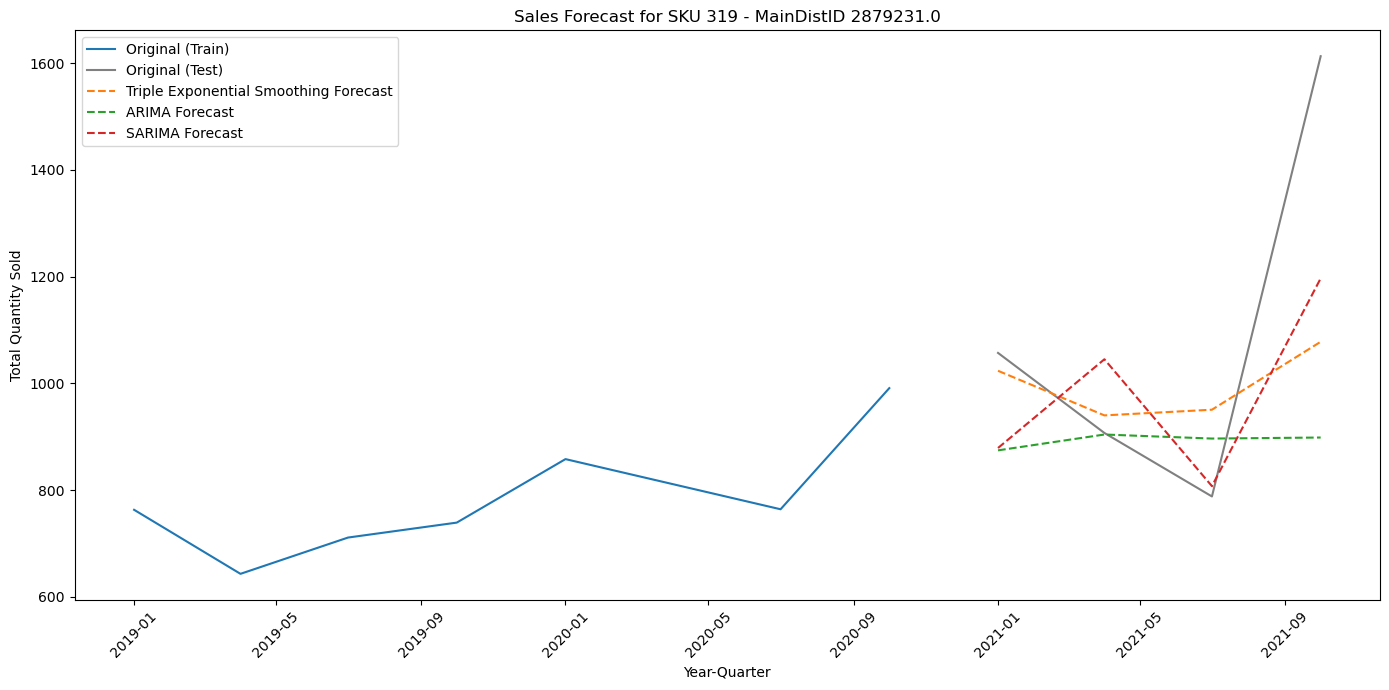

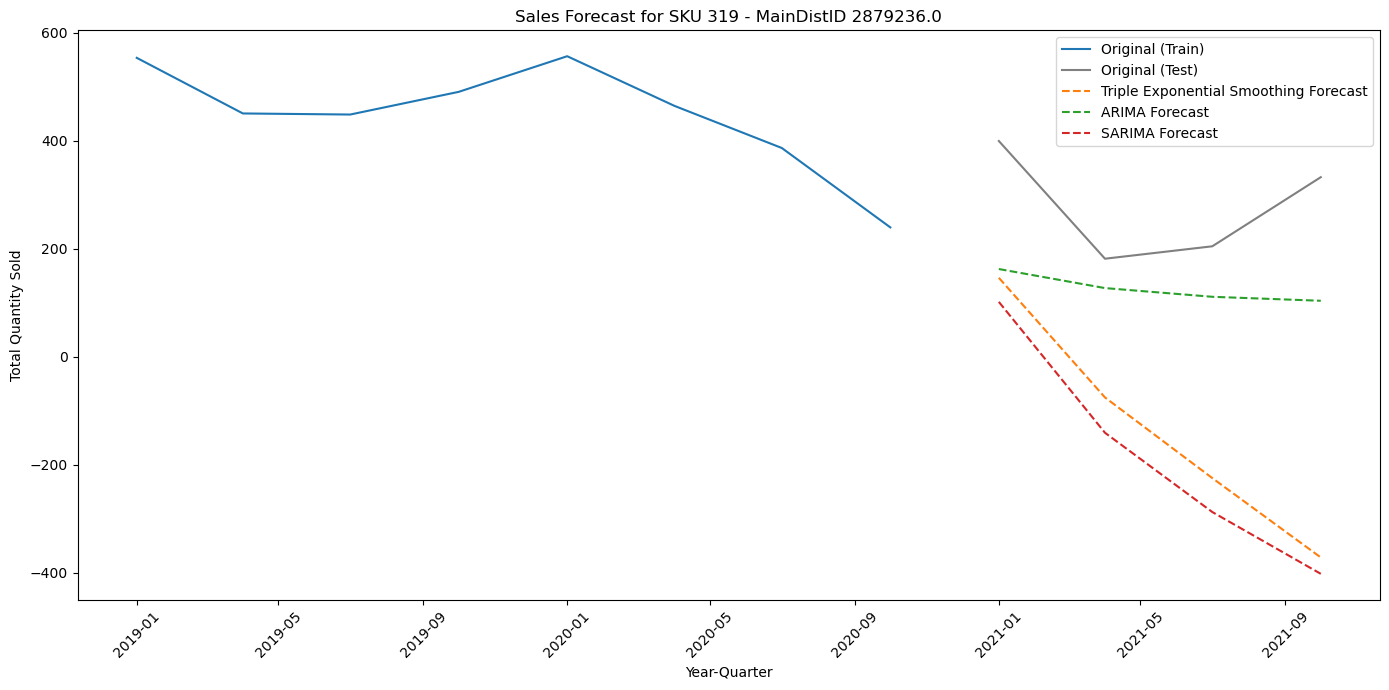

Not enough data for testing forecasting for MainDistID 2879243.0. Skipping.
Not enough data for training forecasting for MainDistID 2879244.0. Skipping.


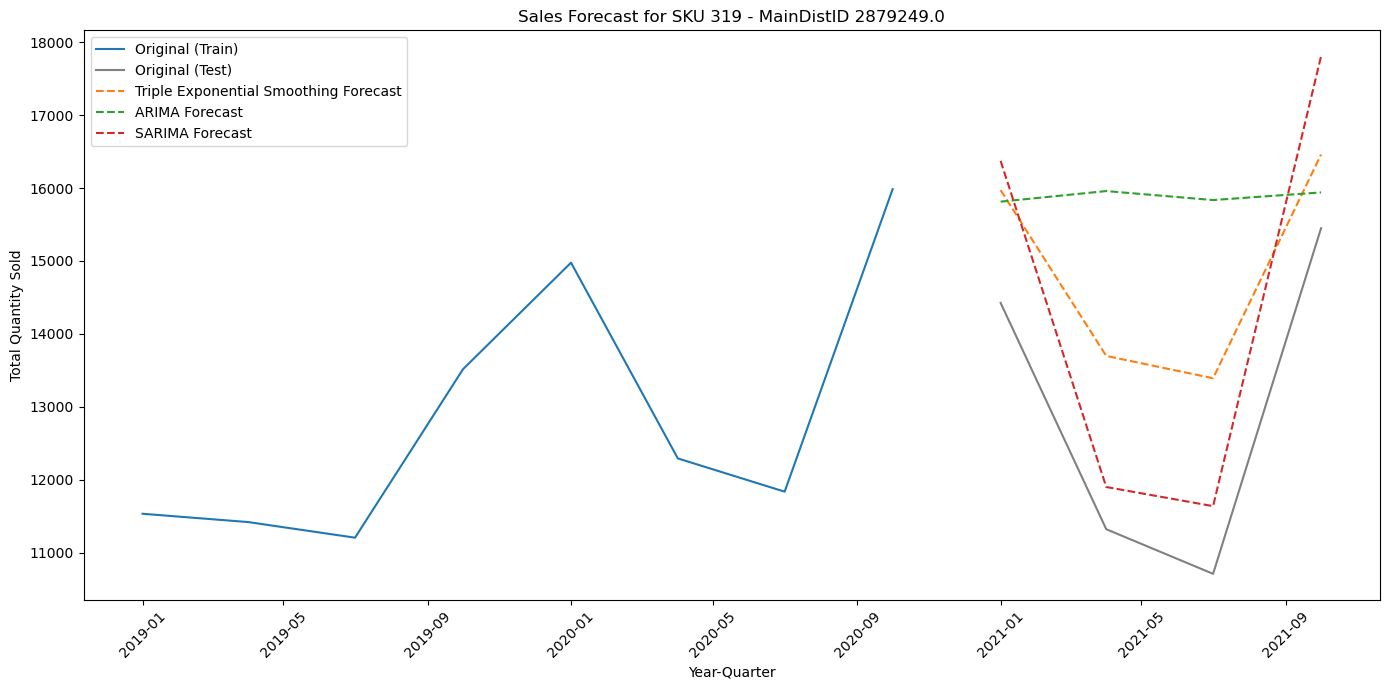

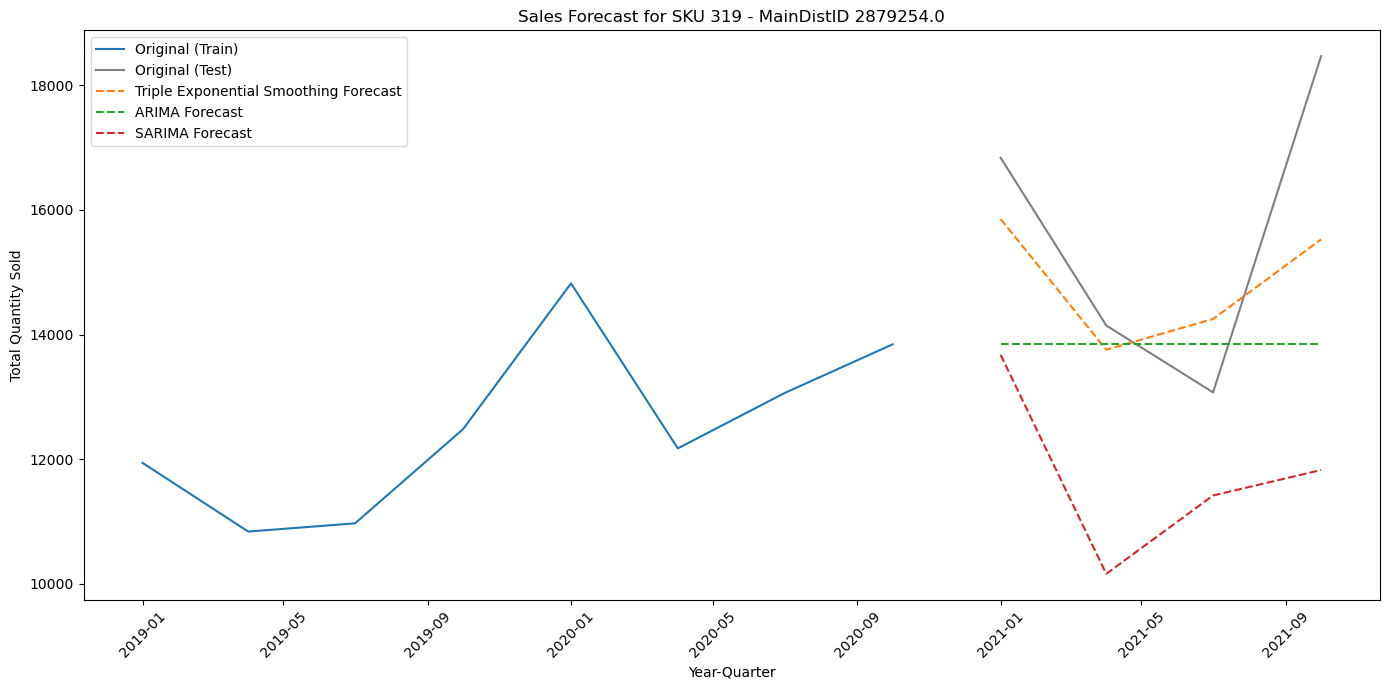

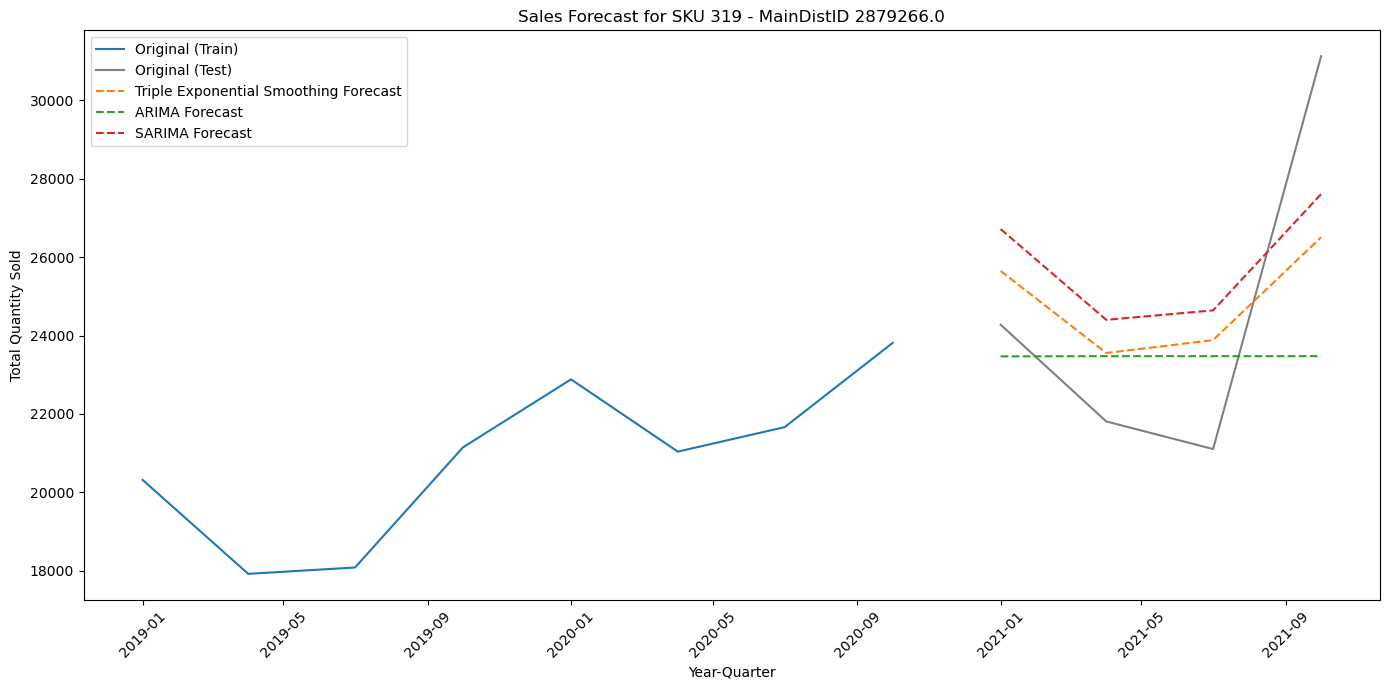

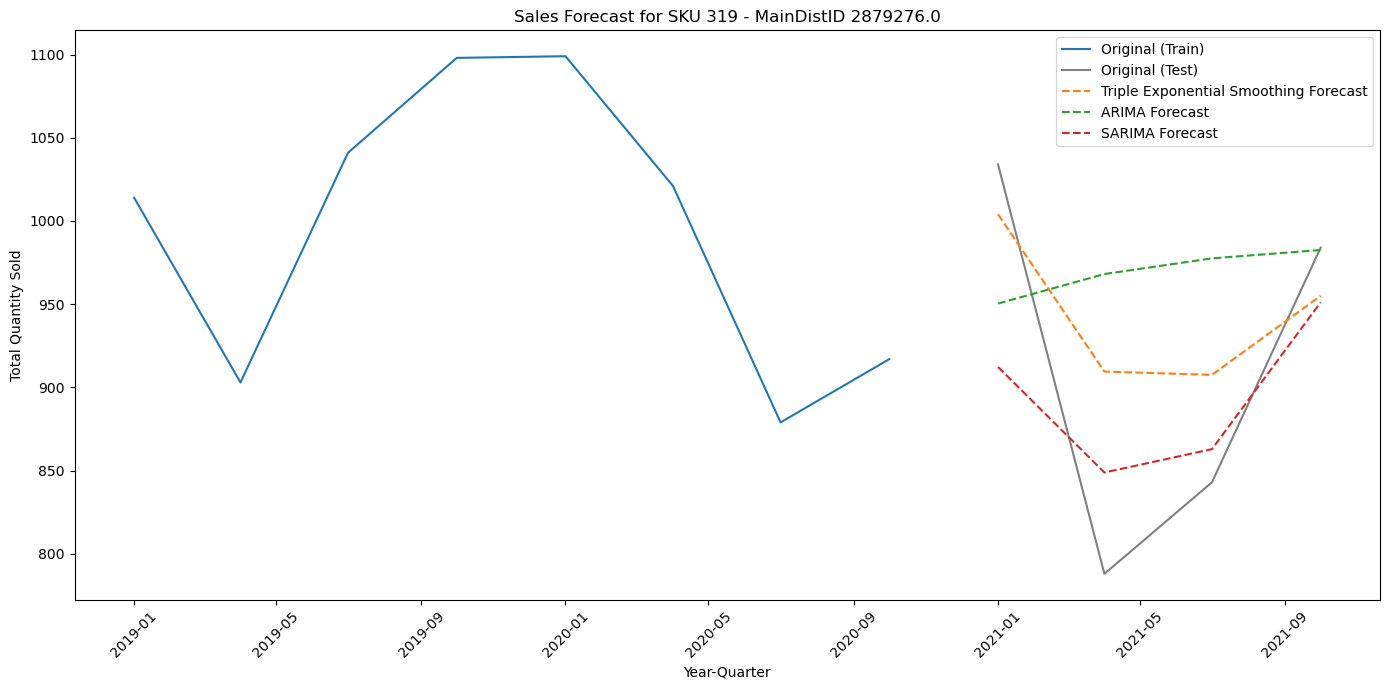

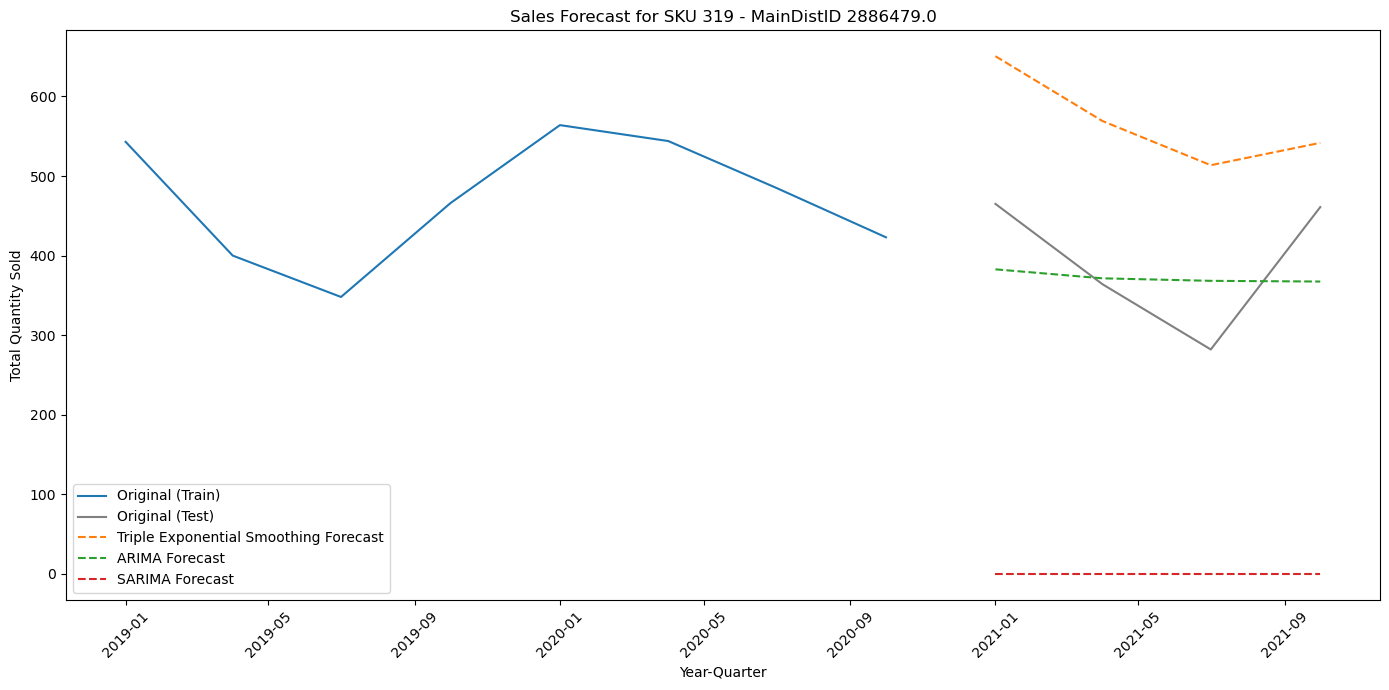

Not enough data for training forecasting for MainDistID 2908099.0. Skipping.
Not enough data for testing forecasting for MainDistID 2879239.0. Skipping.
Not enough data for training forecasting for MainDistID 2879260.0. Skipping.
Not enough data for training forecasting for MainDistID 2879224.0. Skipping.
Not enough data for training forecasting for MainDistID 2915715.0. Skipping.
Not enough data for training forecasting for MainDistID 2918750.0. Skipping.
Not enough data for training forecasting for MainDistID 2879258.0. Skipping.


In [179]:
metrics_df_quarterly = plot_seasonal_forecasts_quarterly('319')

In [180]:
metrics_df_quarterly

MAPE           MSE         RMSE  \
MainDistID Method                                                              
2879231    Triple Exponential Smoothing  0.151515  7.874627e+04   280.617664   
           ARIMA                         0.189172  1.389275e+05   372.729733   
           SARIMA                        0.150848  5.611891e+04   236.894300   
2879236    Triple Exponential Smoothing  1.563408  2.025937e+05   450.104086   
           ARIMA                         0.508775  3.007887e+04   173.432600   
           SARIMA                        1.780497  2.435925e+05   493.550920   
2879249    Triple Exponential Smoothing  0.158275  4.064582e+06  2016.080954   
           ARIMA                         0.254133  1.249120e+07  3534.289522   
           SARIMA                        0.106380  2.637893e+06  1624.159115   
2879254    Triple Exponential Smoothing  0.083824  2.789254e+06  1670.106115   
           ARIMA                         0.127161  7.760760e+06  2785.814015   
           SARIMA                        0.238973  1.818567e+07  4264.466199   
2879266    Triple Exponential Smoothing  0.104200  8.505346e+06  2916.392709   
           ARIMA                         0.116974  1.691118e+07  4112.320864   
           SARIMA                        0.125046  9.398087e+06  3065.629929   
2879276    Triple Exponential Smoothing  0.072301  5.168477e+03    71.892122   
           ARIMA                         0.117630  1.438566e+04   119.940228   
           SARIMA                        0.063001  4.998600e+03    70.700781   
2886479    Triple Exponential Smoothing  0.489801  3.417495e+04   184.864687   
           ARIMA                         0.176594  5.757151e+03    75.875894   
           SARIMA                        1.000000  1.601915e+05   400.239303   

                                                Bias  
MainDistID Method                                     
2879231    Triple Exponential Smoothing   -93.271409  
           ARIMA                         -197.884379  
           SARIMA                        -109.258324  
2879236    Triple Exponential Smoothing  -410.931821  
           ARIMA                         -153.474600  
           SARIMA                        -461.718813  
2879249    Triple Exponential Smoothing  1904.042603  
           ARIMA                         2911.011414  
           SARIMA                        1453.302498  
2879254    Triple Exponential Smoothing  -784.055170  
           ARIMA                        -1787.750215  
           SARIMA                       -3861.459486  
2879266    Triple Exponential Smoothing   319.320013  
           ARIMA                        -1106.769457  
           SARIMA                        1263.490345  
2879276    Triple Exponential Smoothing    31.791544  
           ARIMA                           57.404280  
           SARIMA                         -18.446915  
2886479    Triple Exponential Smoothing   175.773693  
           ARIMA                          -20.533869  
           SARIMA                        -393.000000

In [181]:
metrics_df_quarterly.loc[(2879231, 'ARIMA')]

MAPE         0.189172
MSE     138927.453969
RMSE       372.729733
Bias      -197.884379
Name: (2879231, ARIMA), dtype: float64

In [182]:
metrics_df_quarterly.loc[(2879231, 'SARIMA')]

MAPE        0.150848
MSE     56118.909498
RMSE      236.894300
Bias     -109.258324
Name: (2879231, SARIMA), dtype: float64

In [183]:
metrics_df_quarterly.loc[(2879231, 'Triple Exponential Smoothing')]

MAPE        0.151515
MSE     78746.273210
RMSE      280.617664
Bias      -93.271409
Name: (2879231, Triple Exponential Smoothing), dtype: float64

### Monthly Sales Analysis and Forecasting 

In [184]:
def plot_seasonal_forecasts_monthly(sku_id):
    df = main_dist_data_monthly[main_dist_data_monthly['SkuID'] == sku_id]
    df['Date'] = df.apply(lambda row: f"{row['Year']}-{row['Month']}", axis=1)
    df['Date'] = pd.PeriodIndex(df['Date'], freq='M').to_timestamp()
    df.set_index('Date', inplace=True)
    df = df.drop(columns=['Year', 'Month'])
    
    # Ensure the series is of numeric type
    df = df.astype(float)
    
    metrics = {}
    
    for main_dist_id in df['MainDistID'].unique():
        main_dist_data = df[df['MainDistID'] == main_dist_id]['TotalQuantity']
        train = main_dist_data[:-4]
        test = main_dist_data[-4:]
        
        # Check if the data is not enough
        if len(test) < 4:
            print(f"Not enough data for testing forecasting for MainDistID {main_dist_id}. Skipping.")
            continue
            
        if len(train) < 8:
            print(f"Not enough data for training forecasting for MainDistID {main_dist_id}. Skipping.")
            continue
        
        # Forecasting methods
        triple_exp_smoothing_forecast = TripleExponentialSmoothingForecast(train, forecast_periods=4)
        arima_forecast = ARIMAForecast(train, forecast_periods=4)
        sarima_forecast = SARIMAForecast(train, forecast_periods=4)
        
        # Calculate metrics
        triple_exp_smoothing_mape, triple_exp_smoothing_mse, triple_exp_smoothing_rmse, triple_exp_smoothing_bias = calculate_metrics(test, triple_exp_smoothing_forecast)
        arima_mape, arima_mse, arima_rmse, arima_bias = calculate_metrics(test, arima_forecast)
        sarima_mape, sarima_mse, sarima_rmse, sarima_bias = calculate_metrics(test, sarima_forecast)
        
        metrics[main_dist_id] = {
            'Triple Exponential Smoothing': {'MAPE': triple_exp_smoothing_mape, 'MSE': triple_exp_smoothing_mse, 'RMSE': triple_exp_smoothing_rmse, 'Bias': triple_exp_smoothing_bias},
            'ARIMA': {'MAPE': arima_mape, 'MSE': arima_mse, 'RMSE': arima_rmse, 'Bias': arima_bias},
            'SARIMA': {'MAPE': sarima_mape, 'MSE': sarima_mse, 'RMSE': sarima_rmse, 'Bias': sarima_bias},
        }
        
        # Plotting
        plt.figure(figsize=(14, 7))
        plt.plot(train.index, train, label='Original (Train)')
        plt.plot(test.index, test, label='Original (Test)', color='gray')
        plt.plot(test.index, triple_exp_smoothing_forecast, label='Triple Exponential Smoothing Forecast', linestyle='--')
        plt.plot(test.index, arima_forecast, label='ARIMA Forecast', linestyle='--')
        plt.plot(test.index, sarima_forecast, label='SARIMA Forecast', linestyle='--')
        
        plt.title(f'Sales Forecast for SKU {sku_id} - MainDistID {main_dist_id}')
        plt.xlabel('Year-Month')
        plt.ylabel('Total Quantity Sold')
        plt.legend()
        
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
        
    metrics_df = pd.DataFrame.from_dict({(i,j): metrics[i][j]
                                for i in metrics.keys()
                                for j in metrics[i].keys()},
                                orient='index')
    metrics_df.index = metrics_df.index.rename(['MainDistID', 'Method'])
    metrics_df.index = metrics_df.index.set_levels(metrics_df.index.levels[0].astype(int), level=0)
    
    return metrics_df

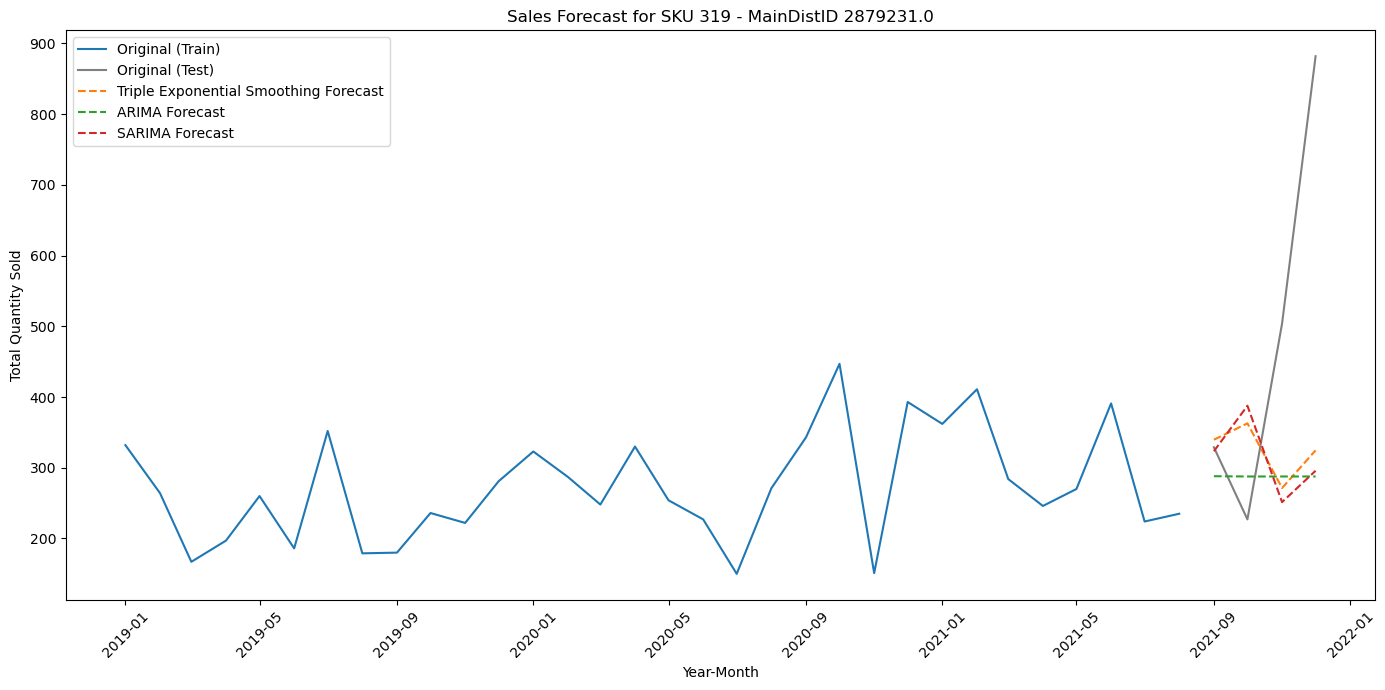

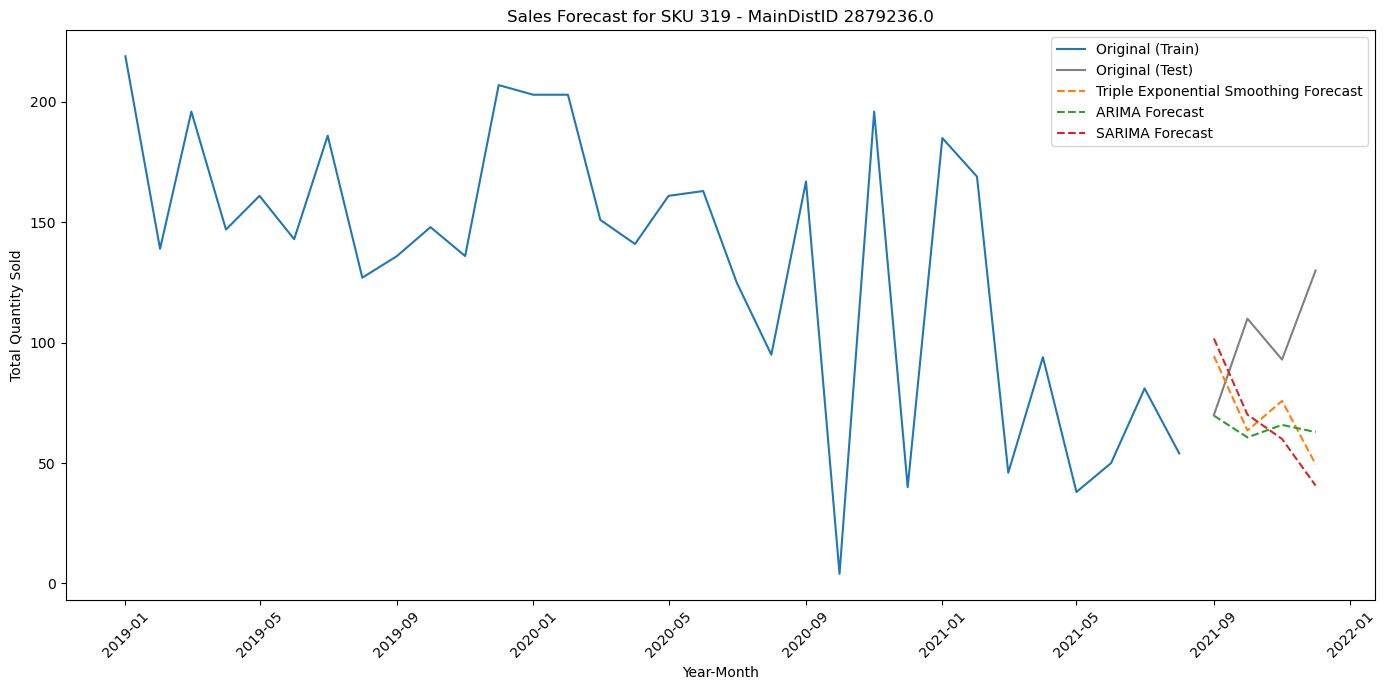

Not enough data for testing forecasting for MainDistID 2879243.0. Skipping.


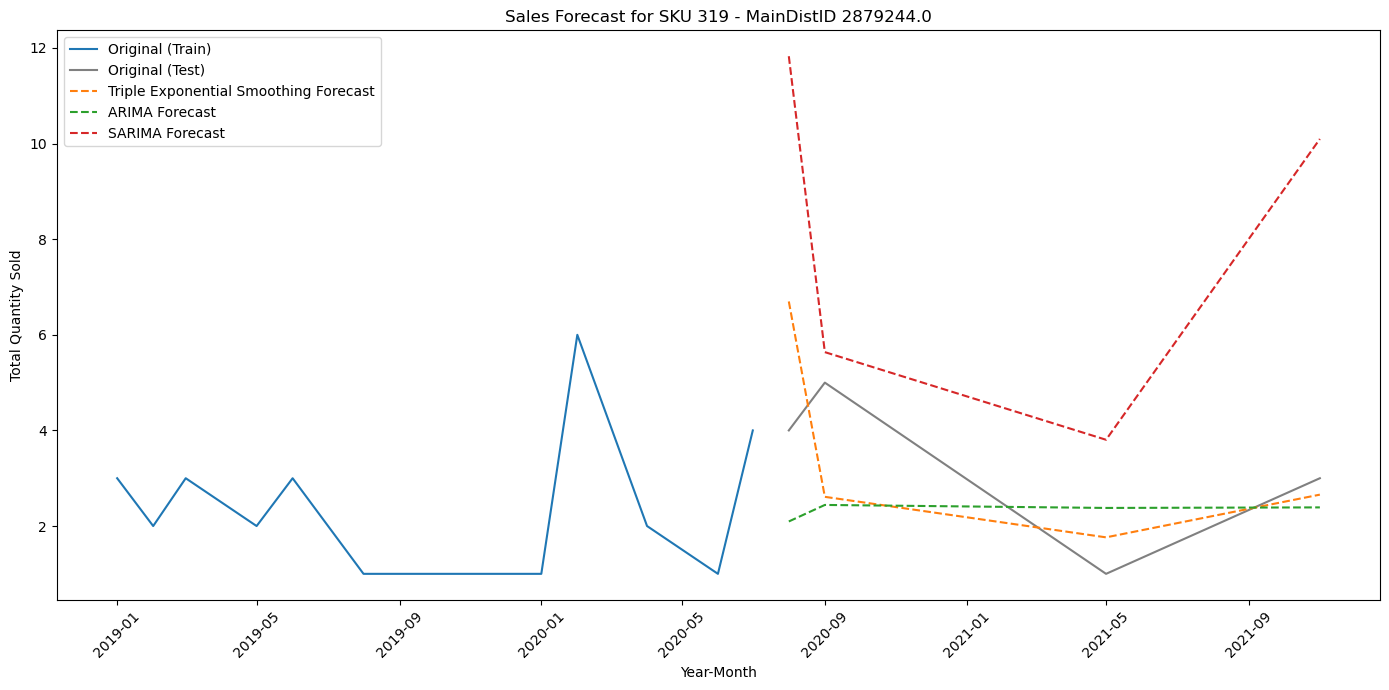

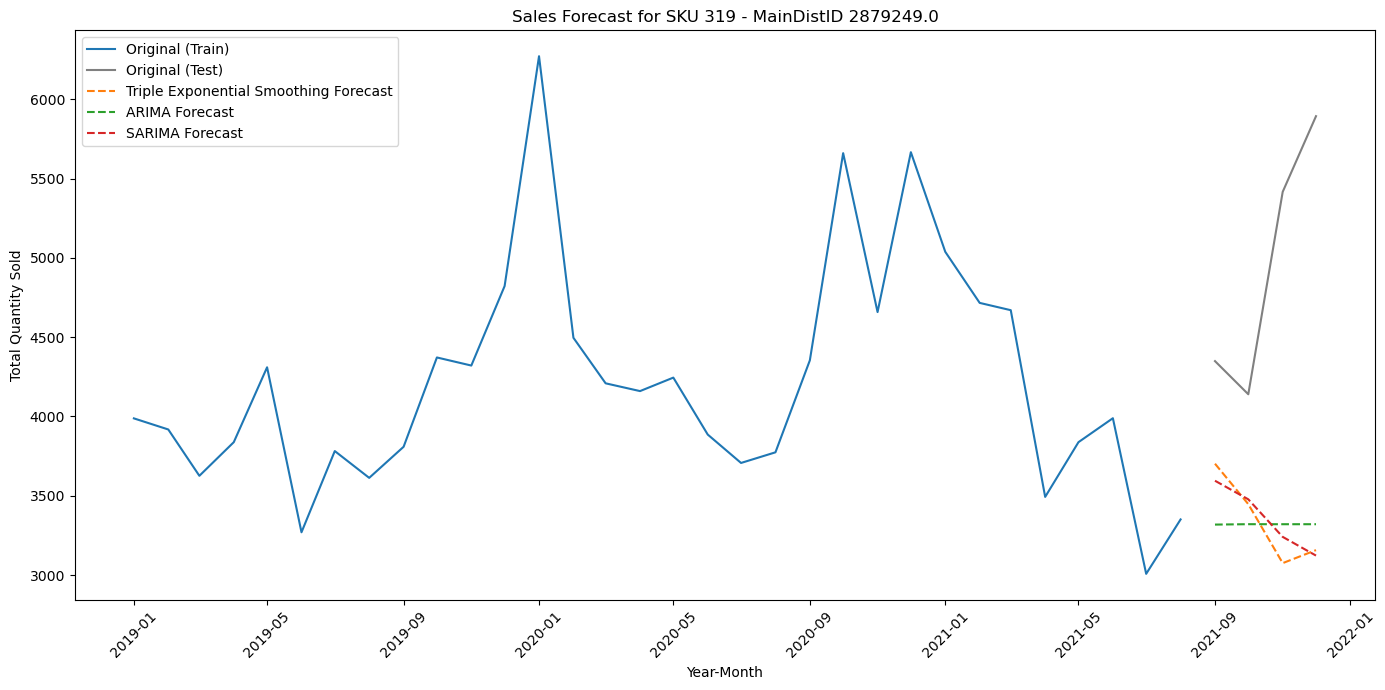

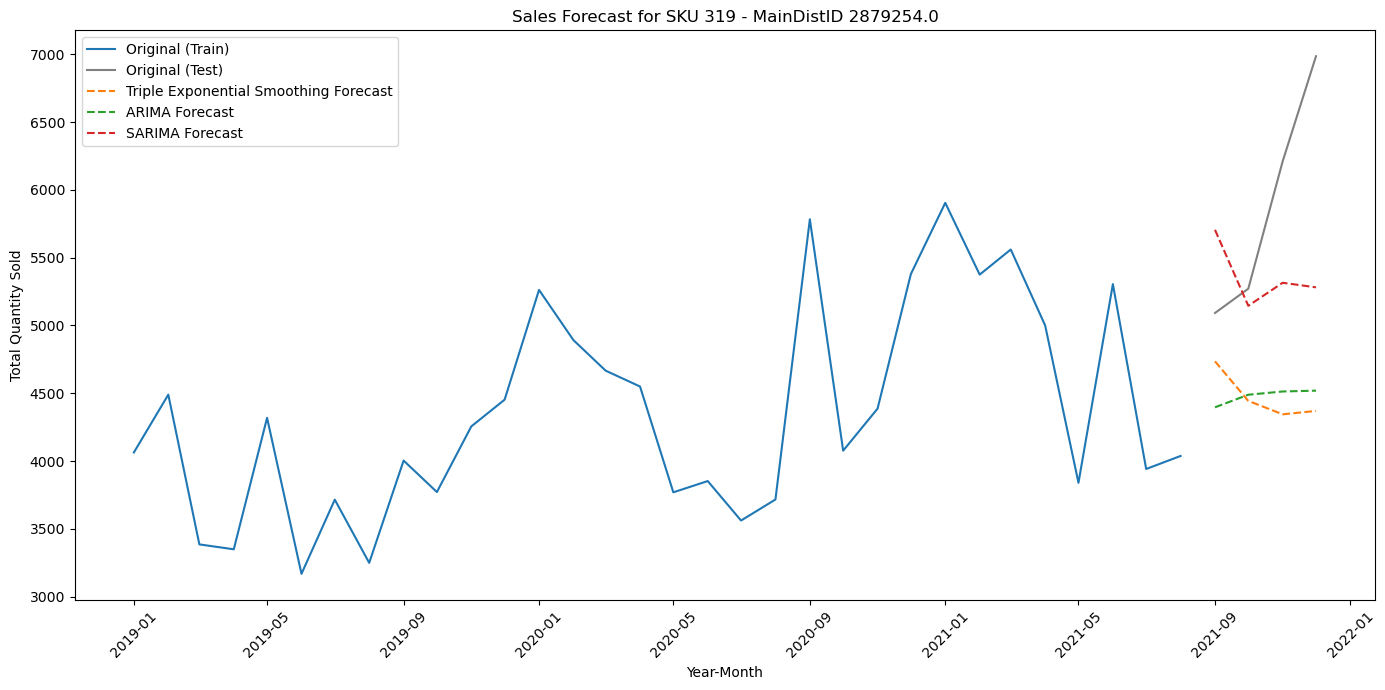

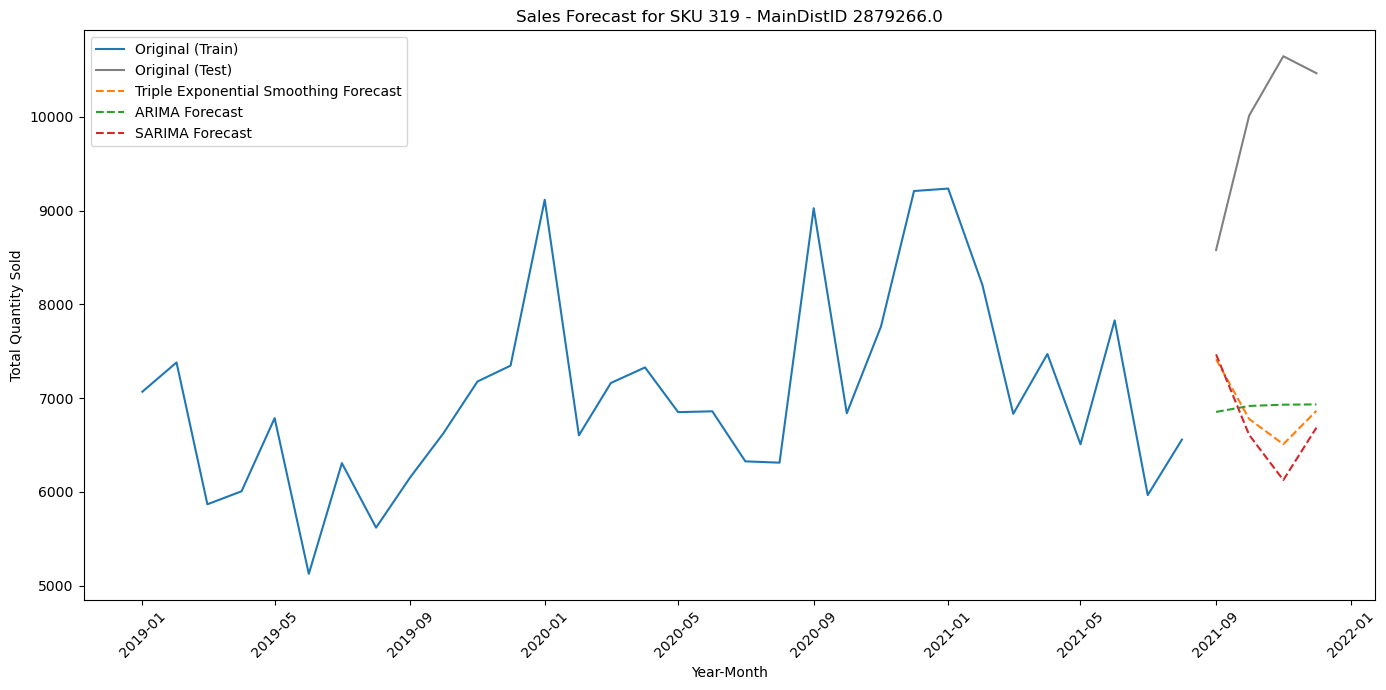

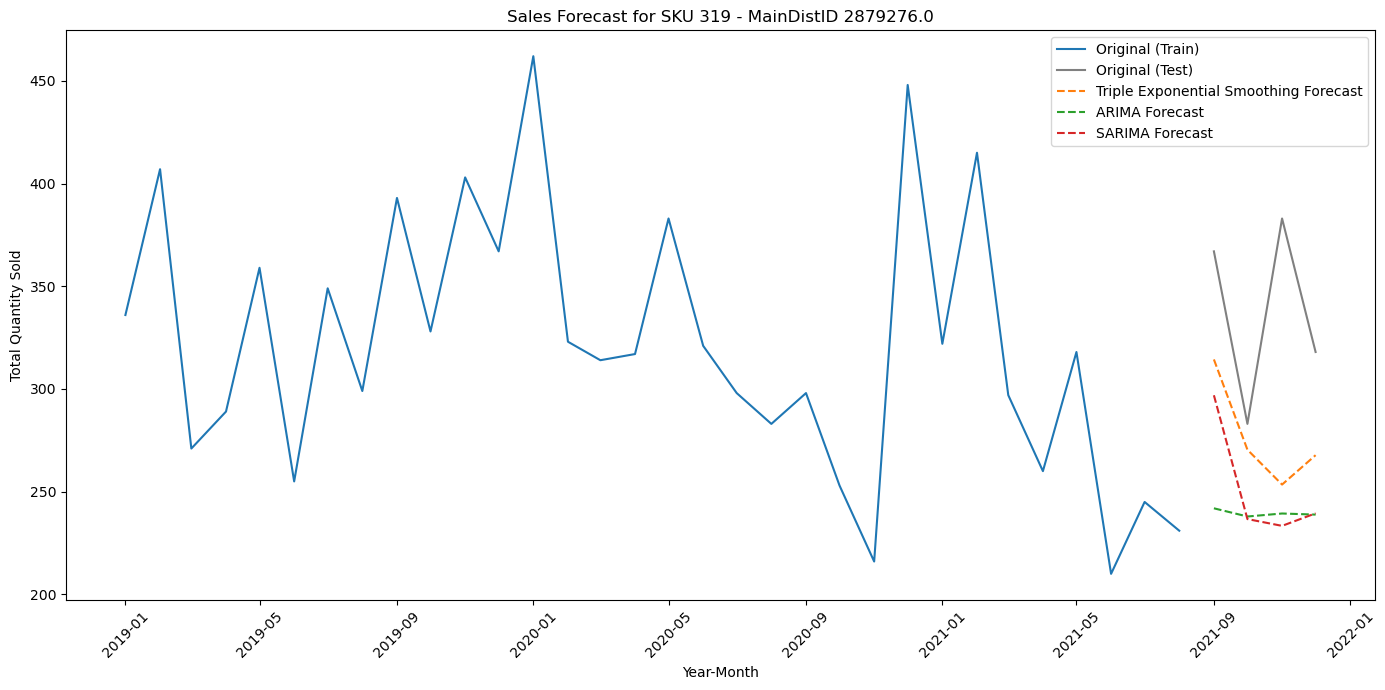

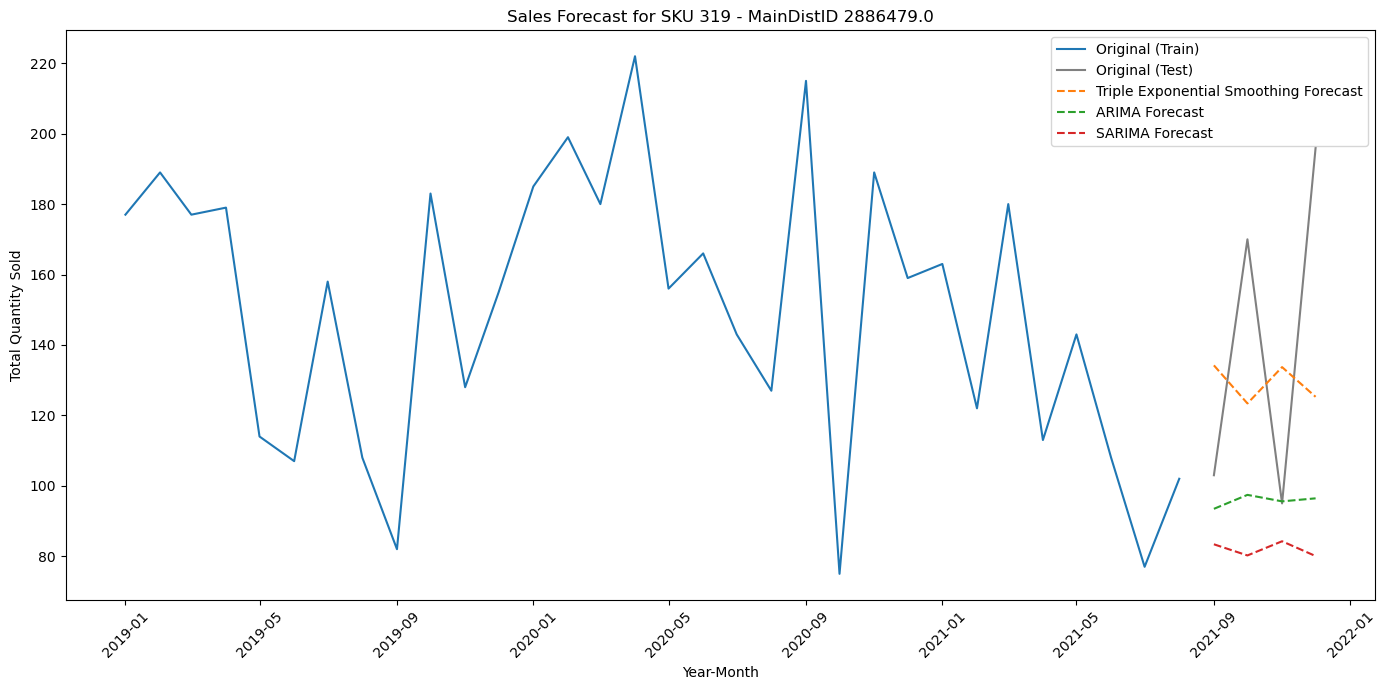

Not enough data for training forecasting for MainDistID 2908099.0. Skipping.
Not enough data for testing forecasting for MainDistID 2879239.0. Skipping.
Not enough data for training forecasting for MainDistID 2879260.0. Skipping.


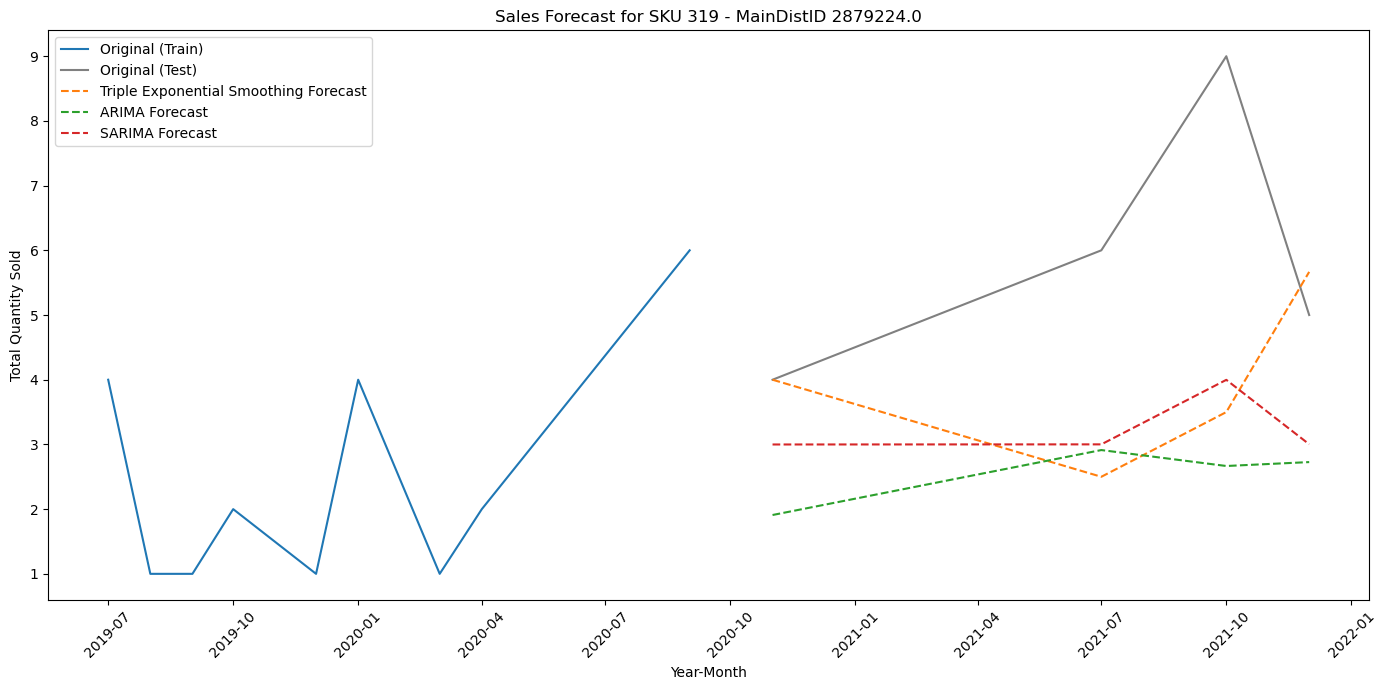

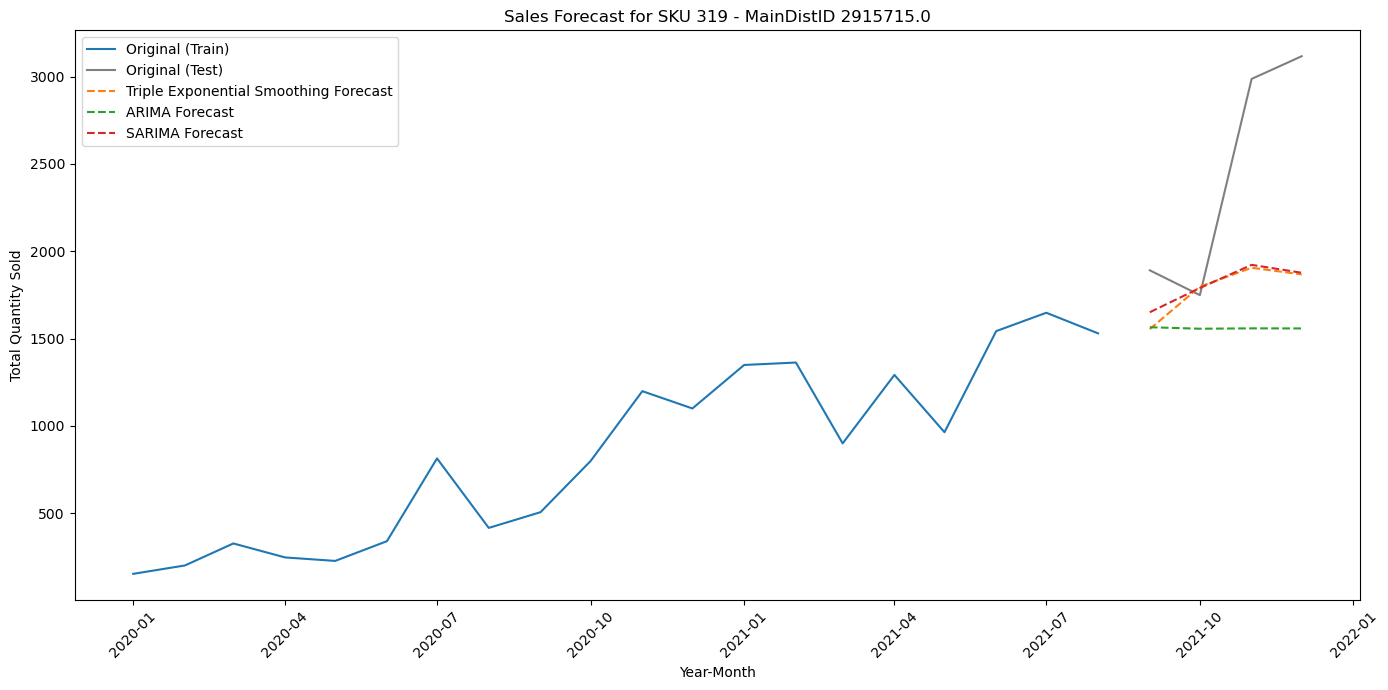

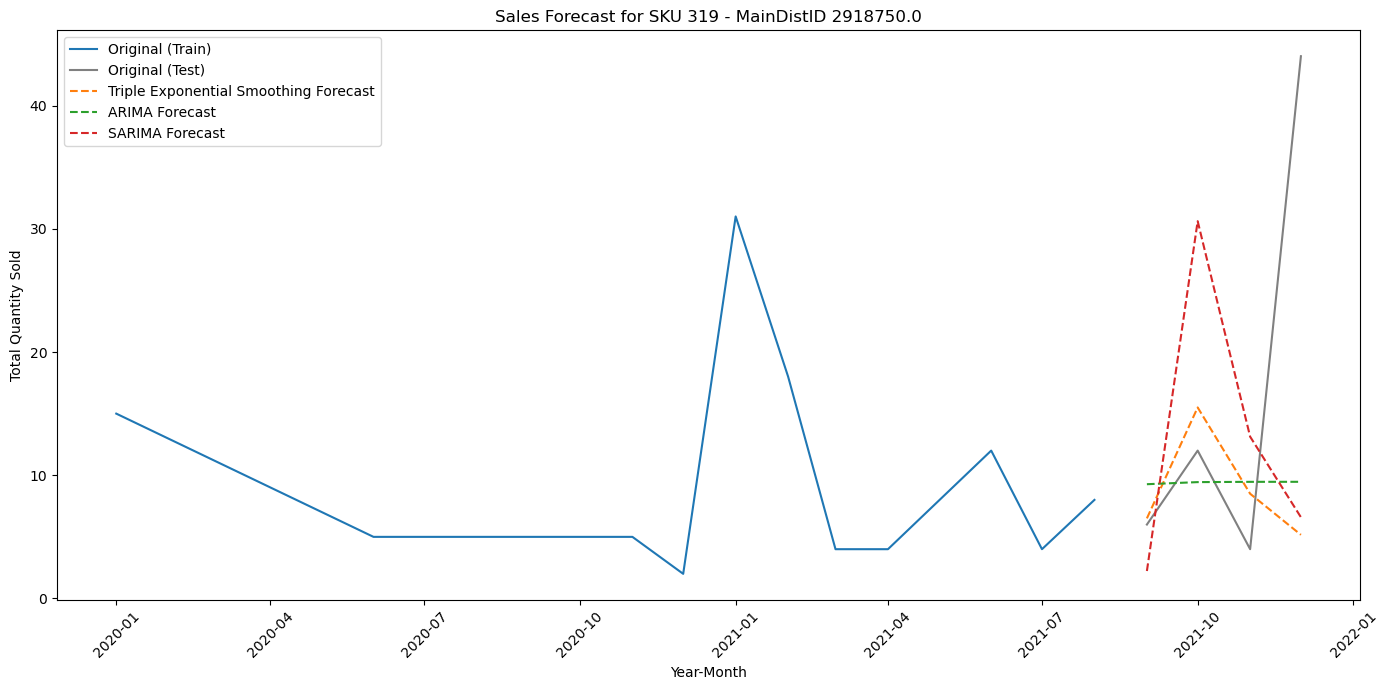

Not enough data for training forecasting for MainDistID 2879258.0. Skipping.


In [185]:
metrics_df_monthly = plot_seasonal_forecasts_monthly('319')

In [186]:
metrics_df_monthly

MAPE           MSE         RMSE  \
MainDistID Method                                                              
2879231    Triple Exponential Smoothing  0.431051  9.583100e+04   309.565819   
           ARIMA                         0.373683  1.013422e+05   318.342840   
           SARIMA                        0.472692  1.083250e+05   329.127707   
2879236    Triple Exponential Smoothing  0.394043  2.383568e+03    48.821795   
           ARIMA                         0.315166  1.918243e+03    43.797751   
           SARIMA                        0.464334  2.916115e+03    54.001065   
2879244    Triple Exponential Smoothing       NaN           NaN          NaN   
           ARIMA                              NaN           NaN          NaN   
           SARIMA                             NaN           NaN          NaN   
2879249    Triple Exponential Smoothing  0.303089  3.464623e+06  1861.349652   
           ARIMA                         0.314530  3.184682e+06  1784.567653   
           SARIMA                        0.301254  3.352726e+06  1831.045003   
2879254    Triple Exponential Smoothing  0.225432  2.782984e+06  1668.227835   
           ARIMA                         0.227781  2.513737e+06  1585.476962   
           SARIMA                        0.133125  1.024483e+06  1012.167310   
2879266    Triple Exponential Smoothing  0.297995  1.048658e+07  3238.298433   
           ARIMA                         0.299338  9.721491e+06  3117.930614   
           SARIMA                        0.313970  1.189777e+07  3449.314125   
2879276    Triple Exponential Smoothing  0.171007  5.557834e+03    74.550879   
           ARIMA                         0.281027  1.114399e+04   105.565119   
           SARIMA                        0.248085  8.904497e+03    94.363642   
2886479    Triple Exponential Smoothing  0.336362  2.411619e+03    49.108237   
           ARIMA                         0.258409  3.817662e+03    61.787232   
           SARIMA                        0.355796  5.500864e+03    74.167808   
2879224    Triple Exponential Smoothing       NaN           NaN          NaN   
           ARIMA                              NaN           NaN          NaN   
           SARIMA                             NaN           NaN          NaN   
2915715    Triple Exponential Smoothing  0.242173  7.115511e+05   843.534868   
           ARIMA                         0.315161  1.153344e+06  1073.938573   
           SARIMA                        0.226102  6.825907e+05   826.190481   
2918750    Triple Exponential Smoothing       NaN           NaN          NaN   
           ARIMA                              NaN           NaN          NaN   
           SARIMA                             NaN           NaN          NaN   

                                                Bias  
MainDistID Method                                     
2879231    Triple Exponential Smoothing  -160.870830  
           ARIMA                         -197.722809  
           SARIMA                        -170.922161  
2879236    Triple Exponential Smoothing   -29.914101  
           ARIMA                          -35.966740  
           SARIMA                         -32.614066  
2879244    Triple Exponential Smoothing          NaN  
           ARIMA                                 NaN  
           SARIMA                                NaN  
2879249    Triple Exponential Smoothing -1603.839226  
           ARIMA                        -1629.227410  
           SARIMA                       -1590.359679  
2879254    Triple Exponential Smoothing -1416.147716  
           ARIMA                        -1410.001907  
           SARIMA                        -528.257907  
2879266    Triple Exponential Smoothing -3036.108751  
           ARIMA                        -3019.088212  
           SARIMA                       -3205.900679  
2879276    Triple Exponential Smoothing   -61.244069  
           ARIMA                          -98.241854  
           SARIMA                 

In [187]:
metrics_df_monthly.loc[(2879231, 'ARIMA')]

MAPE         0.373683
MSE     101342.163594
RMSE       318.342840
Bias      -197.722809
Name: (2879231, ARIMA), dtype: float64

In [188]:
metrics_df_monthly.loc[(2879231, 'SARIMA')]

MAPE         0.472692
MSE     108325.047835
RMSE       329.127707
Bias      -170.922161
Name: (2879231, SARIMA), dtype: float64

In [189]:
metrics_df_monthly.loc[(2879231, 'Triple Exponential Smoothing')]

MAPE        0.431051
MSE     95830.996047
RMSE      309.565819
Bias     -160.870830
Name: (2879231, Triple Exponential Smoothing), dtype: float64

# Comparison of Forecasting Methods

## Bias = (Actual - Forecasted) / n 
 Bias is the average of the differences between the forecasted values and the actual values. It is a measure of the accuracy of the forecasting method. The closer the bias value is to zero, the more accurate the forecasting method is.


### Bias Values of Forecasting Methods


In [190]:
bias_values = pd.concat([metrics_df_quarterly['Bias'], metrics_df_monthly['Bias']], axis=1)
bias_values.columns = ['Quarterly', 'Monthly']
bias_values


Quarterly      Monthly
MainDistID Method                                                
2879231    Triple Exponential Smoothing   -93.271409  -160.870830
           ARIMA                         -197.884379  -197.722809
           SARIMA                        -109.258324  -170.922161
2879236    Triple Exponential Smoothing  -410.931821   -29.914101
           ARIMA                         -153.474600   -35.966740
           SARIMA                        -461.718813   -32.614066
2879249    Triple Exponential Smoothing  1904.042603 -1603.839226
           ARIMA                         2911.011414 -1629.227410
           SARIMA                        1453.302498 -1590.359679
2879254    Triple Exponential Smoothing  -784.055170 -1416.147716
           ARIMA                        -1787.750215 -1410.001907
           SARIMA                       -3861.459486  -528.257907
2879266    Triple Exponential Smoothing   319.320013 -3036.108751
           ARIMA                        -1106.769457 -3019.088212
           SARIMA                        1263.490345 -3205.900679
2879276    Triple Exponential Smoothing    31.791544   -61.244069
           ARIMA                           57.404280   -98.241854
           SARIMA                         -18.446915   -86.146172
2886479    Triple Exponential Smoothing   175.773693   -11.853489
           ARIMA                          -20.533869   -45.272022
           SARIMA                        -393.000000   -59.020155
2879244    Triple Exponential Smoothing          NaN          NaN
           ARIMA                                 NaN          NaN
           SARIMA                                NaN          NaN
2879224    Triple Exponential Smoothing          NaN          NaN
           ARIMA                                 NaN          NaN
           SARIMA                                NaN          NaN
2915715    Triple Exponential Smoothing          NaN  -654.753558
           ARIMA                                 NaN  -876.370370
           SARIMA                                NaN  -625.970351
2918750    Triple Exponential Smoothing          NaN          NaN
           ARIMA                                 NaN          NaN
           SARIMA                                NaN          NaN

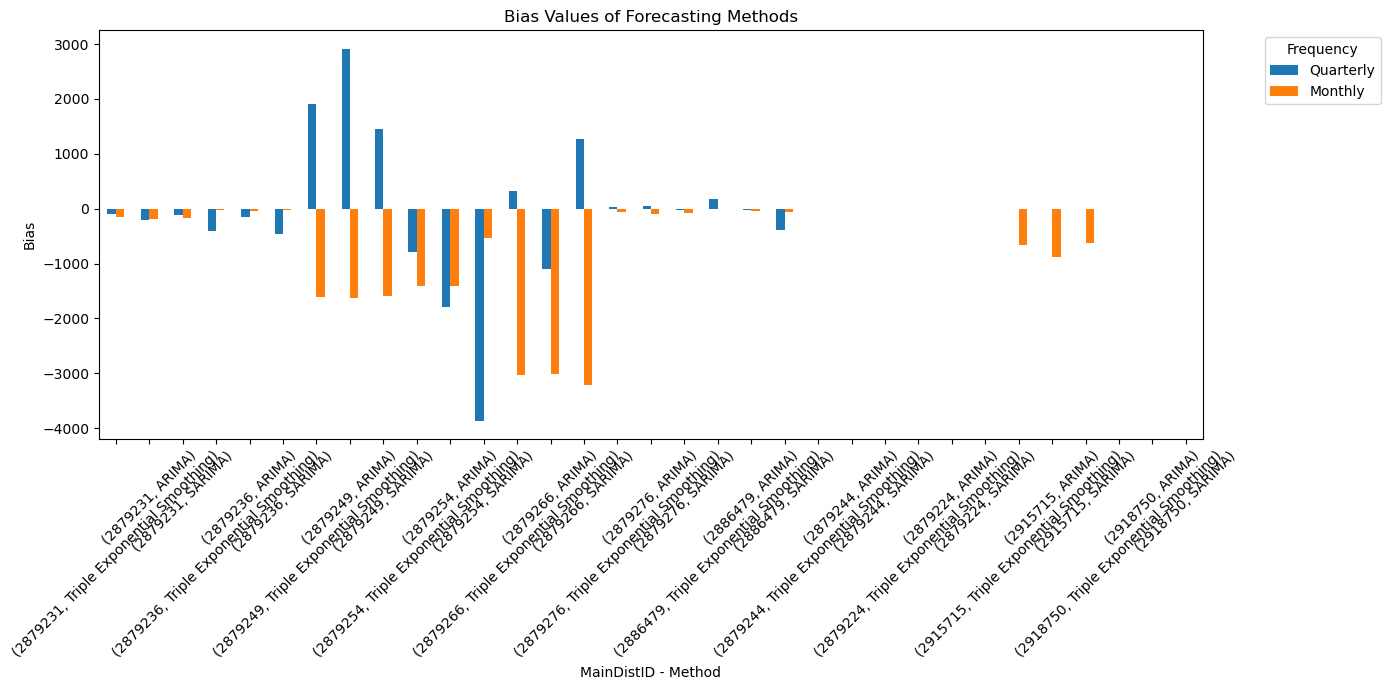

In [191]:
# plot the bias values
bias_values.plot(kind='bar', figsize=(14, 7))
plt.title('Bias Values of Forecasting Methods')
plt.xlabel('MainDistID - Method')
plt.ylabel('Bias')
plt.legend(title='Frequency', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Mean Absolute Percentage Error (MAPE) Values of Forecasting Methods

In [192]:
mape_values = pd.concat([metrics_df_quarterly['MAPE'], metrics_df_monthly['MAPE']], axis=1)
mape_values.columns = ['Quarterly', 'Monthly']
mape_values

Quarterly   Monthly
MainDistID Method                                           
2879231    Triple Exponential Smoothing   0.151515  0.431051
           ARIMA                          0.189172  0.373683
           SARIMA                         0.150848  0.472692
2879236    Triple Exponential Smoothing   1.563408  0.394043
           ARIMA                          0.508775  0.315166
           SARIMA                         1.780497  0.464334
2879249    Triple Exponential Smoothing   0.158275  0.303089
           ARIMA                          0.254133  0.314530
           SARIMA                         0.106380  0.301254
2879254    Triple Exponential Smoothing   0.083824  0.225432
           ARIMA                          0.127161  0.227781
           SARIMA                         0.238973  0.133125
2879266    Triple Exponential Smoothing   0.104200  0.297995
           ARIMA                          0.116974  0.299338
           SARIMA                         0.125046  0.313970
2879276    Triple Exponential Smoothing   0.072301  0.171007
           ARIMA                          0.117630  0.281027
           SARIMA                         0.063001  0.248085
2886479    Triple Exponential Smoothing   0.489801  0.336362
           ARIMA                          0.176594  0.258409
           SARIMA                         1.000000  0.355796
2879244    Triple Exponential Smoothing        NaN       NaN
           ARIMA                               NaN       NaN
           SARIMA                              NaN       NaN
2879224    Triple Exponential Smoothing        NaN       NaN
           ARIMA                               NaN       NaN
           SARIMA                              NaN       NaN
2915715    Triple Exponential Smoothing        NaN  0.242173
           ARIMA                               NaN  0.315161
           SARIMA                              NaN  0.226102
2918750    Triple Exponential Smoothing        NaN       NaN
           ARIMA                               NaN       NaN
           SARIMA                              NaN       NaN

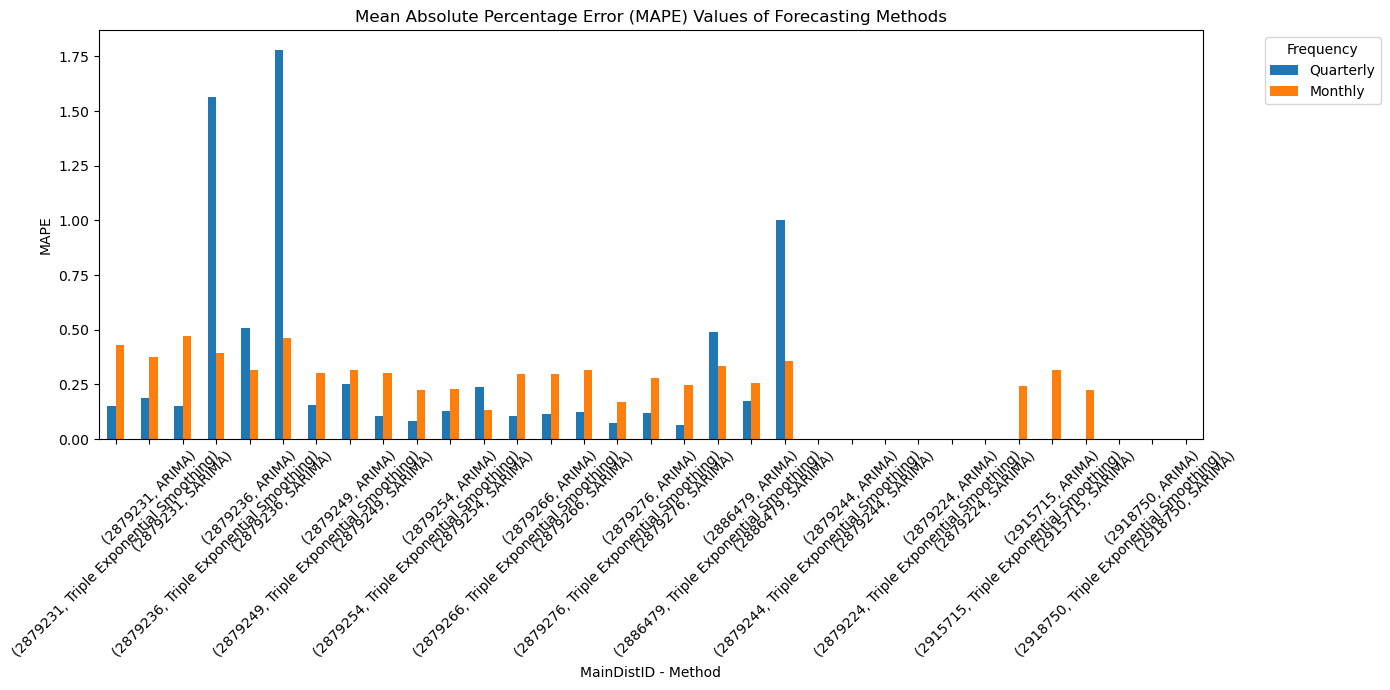

In [193]:
# plot the MAPE values
mape_values.plot(kind='bar', figsize=(14, 7))
plt.title('Mean Absolute Percentage Error (MAPE) Values of Forecasting Methods')
plt.xlabel('MainDistID - Method')
plt.ylabel('MAPE')
plt.legend(title='Frequency', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()